In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [ ]:
# Read the datasets
def load_and_preprocess_data(dataset_num):
    """
    Load and preprocess both concentration and covariate data for a given dataset number.
    This function handles data loading, categorical variable encoding, and numerical scaling.
    """
    # Load concentration data
    conc_data = pd.read_csv(f'dataset{dataset_num}_concentration.csv')

    # Load covariates data
    cov_data = pd.read_csv(f'dataset{dataset_num}_covariates.csv')

    # Convert categorical variables to dummy variables
    cov_data_processed = pd.get_dummies(cov_data, columns=['sex', 'race'])

    # Scale numerical covariates
    scaler = StandardScaler()
    numerical_cols = ['age', 'weight', 'hemoglobine', 'albumine']
    cov_data_processed[numerical_cols] = scaler.fit_transform(cov_data_processed[numerical_cols])

    return conc_data, cov_data, cov_data_processed

# Load both datasets
print("Loading and preprocessing datasets...")
conc_data1, cov_data1, cov_processed1 = load_and_preprocess_data(1)
conc_data2, cov_data2, cov_processed2 = load_and_preprocess_data(2)

# Print basic information about the datasets
print("\nDataset 1 shapes:")
print(f"Concentration data: {conc_data1.shape}")
print(f"Covariates data: {cov_data1.shape}")
print(f"Processed covariates data: {cov_processed1.shape}")
print("\nDataset 2 shapes:")
print(f"Concentration data: {conc_data2.shape}")
print(f"Covariates data: {cov_data2.shape}")
print(f"Processed covariates data: {cov_processed2.shape}")

# Display the first few rows of processed data to verify structure
print("\nFirst few rows of processed covariates (Dataset 1):")
print(cov_processed1.head())

Loading and preprocessing datasets...

Dataset 1 shapes:
Concentration data: (10000, 50)
Covariates data: (10000, 13)
Processed covariates data: (10000, 18)

Dataset 2 shapes:
Concentration data: (10000, 50)
Covariates data: (10000, 13)
Processed covariates data: (10000, 18)

First few rows of processed covariates (Dataset 1):
        age    weight  SNP  hemoglobine  albumine  last_dose_time  \
0 -0.050169 -1.818181    1    -0.115761  0.789860              52   
1 -0.128692  0.891557    1    -1.628939 -0.187478              52   
2  0.185401 -1.926856    3     1.304365 -0.668076              52   
3 -0.599831  1.071729    3    -2.383698 -0.096567              52   
4  0.970634 -0.587180    2    -2.258161 -0.212365              52   

   mg_twice_daily_dose  blood_conc          CL            V        ke  \
0             1.558692    6.099252   83.505054  2508.682376  0.033286   
1             5.596025    8.692098   50.351950  4097.639377  0.012288   
2             4.211476   12.968132  1

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

def train_tree_based_models(conc_data, cov_data_processed, time_point):
    """
    Train and evaluate Random Forest and Gradient Boosting models for a specific time point.

    Parameters:
    - conc_data: DataFrame containing concentration measurements
    - cov_data_processed: DataFrame containing processed covariates
    - time_point: The time point to predict (e.g., 2, 3, 5, etc.)

    Returns:
    - Dictionary containing model results and feature importance
    """
    # Prepare features (excluding derived PK parameters and dosing information)
    feature_cols = ['age', 'weight', 'SNP', 'hemoglobine', 'albumine',
                   'sex_female', 'sex_male',
                   'race_African-American', 'race_Asian', 'race_Caucasian-American',
                   'race_Hispanic', 'race_Other']

    X = cov_data_processed[feature_cols]
    y = conc_data[f't{time_point}']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models with parameters tuned for pharmacokinetic data
    rf_model = RandomForestRegressor(
        n_estimators=100,     # Number of trees
        max_depth=10,         # Control tree complexity
        min_samples_leaf=5,   # Minimum samples in leaf nodes
        random_state=42
    )

    gb_model = GradientBoostingRegressor(
        n_estimators=100,     # Number of boosting stages
        learning_rate=0.1,    # Step size
        max_depth=5,          # Tree depth
        random_state=42
    )

    # Dictionary to store results
    results = {}

    # Train and evaluate each model
    for name, model in [('RandomForest', rf_model), ('GradientBoosting', gb_model)]:
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Get feature importance
        importance = model.feature_importances_
        feature_importance = dict(zip(feature_cols, importance))

        # Store results
        results[name] = {
            'r2': r2,
            'rmse': rmse,
            'feature_importance': feature_importance,
            'model': model
        }

    return results

# Define time points for analysis
time_points = [2, 3, 5, 10, 24]

# Run analysis for both datasets
print("Training models for Dataset 1...")
results_dataset1 = {t: train_tree_based_models(conc_data1, cov_processed1, t)
                   for t in time_points}

print("\nTraining models for Dataset 2...")
results_dataset2 = {t: train_tree_based_models(conc_data2, cov_processed2, t)
                   for t in time_points}

# Print results in a structured format
for dataset_num, results in [(1, results_dataset1), (2, results_dataset2)]:
    print(f"\nDataset {dataset_num} Results:")
    for t in time_points:
        print(f"\nTime point {t}h:")
        for model_name in results[t].keys():
            r2 = results[t][model_name]['r2']
            rmse = results[t][model_name]['rmse']
            print(f"{model_name}:")
            print(f"  R² Score: {r2:.3f}")
            print(f"  RMSE: {rmse:.4f}")

            # Print top 3 most important features
            importance = results[t][model_name]['feature_importance']
            top_features = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)[:3])
            print("  Top 3 features:")
            for feat, imp in top_features.items():
                print(f"    {feat}: {imp:.3f}")

Training models for Dataset 1...

Training models for Dataset 2...

Dataset 1 Results:

Time point 2h:
RandomForest:
  R² Score: -0.008
  RMSE: 0.0567
  Top 3 features:
    albumine: 0.258
    hemoglobine: 0.251
    weight: 0.239
GradientBoosting:
  R² Score: -0.040
  RMSE: 0.0576
  Top 3 features:
    weight: 0.264
    hemoglobine: 0.264
    albumine: 0.242

Time point 3h:
RandomForest:
  R² Score: -0.007
  RMSE: 0.0557
  Top 3 features:
    albumine: 0.260
    weight: 0.250
    hemoglobine: 0.243
GradientBoosting:
  R² Score: -0.040
  RMSE: 0.0566
  Top 3 features:
    hemoglobine: 0.265
    weight: 0.255
    albumine: 0.241

Time point 5h:
RandomForest:
  R² Score: -0.005
  RMSE: 0.0475
  Top 3 features:
    weight: 0.252
    albumine: 0.241
    hemoglobine: 0.234
GradientBoosting:
  R² Score: -0.026
  RMSE: 0.0480
  Top 3 features:
    weight: 0.258
    hemoglobine: 0.252
    albumine: 0.231

Time point 10h:
RandomForest:
  R² Score: 0.023
  RMSE: 0.0321
  Top 3 features:
    weigh


Visualizing Feature Importance for Dataset 1, Time Point 2h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


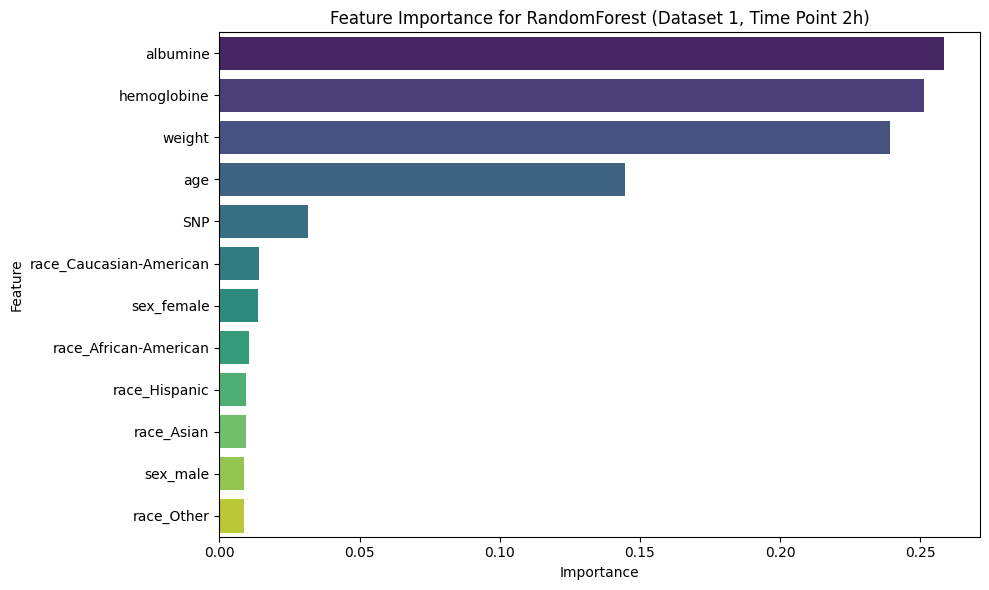

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


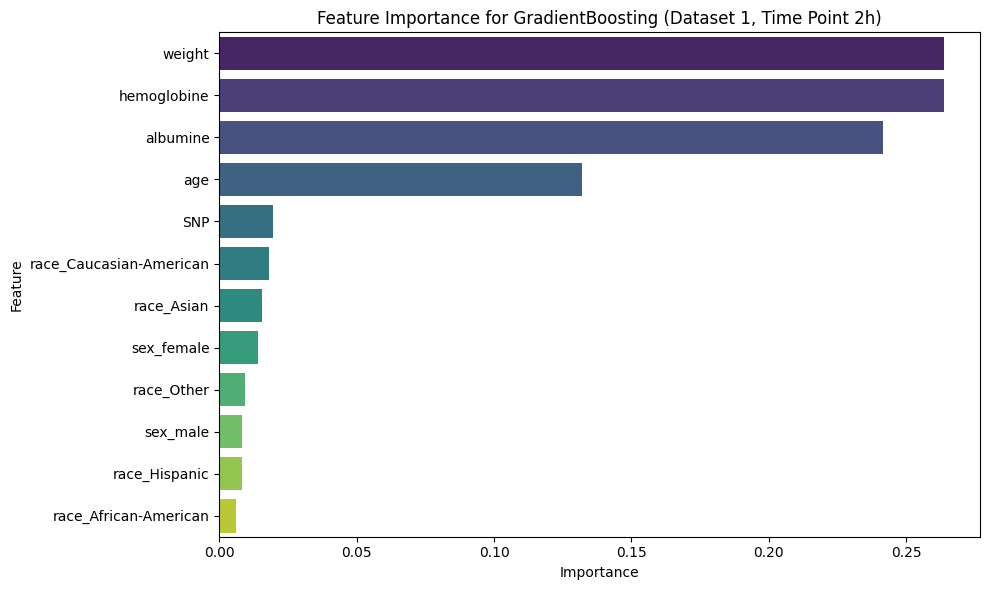


Visualizing Feature Importance for Dataset 2, Time Point 2h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


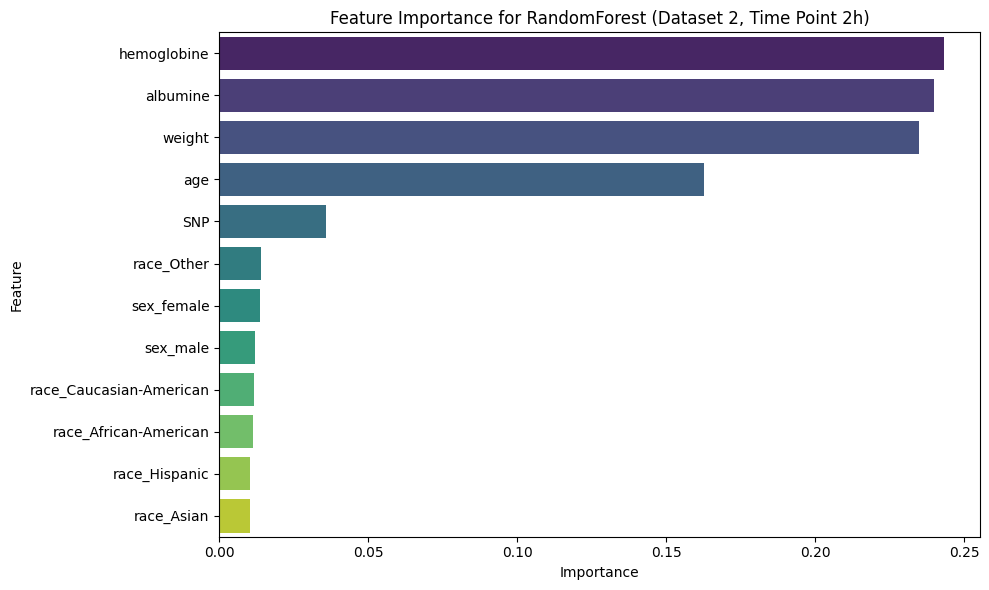

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


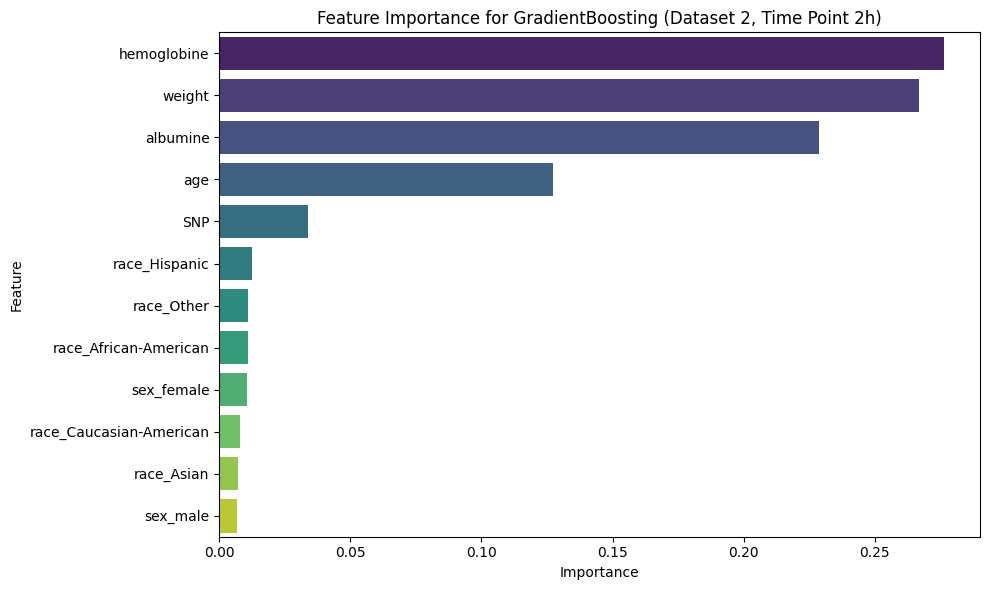


Visualizing Feature Importance for Dataset 1, Time Point 3h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


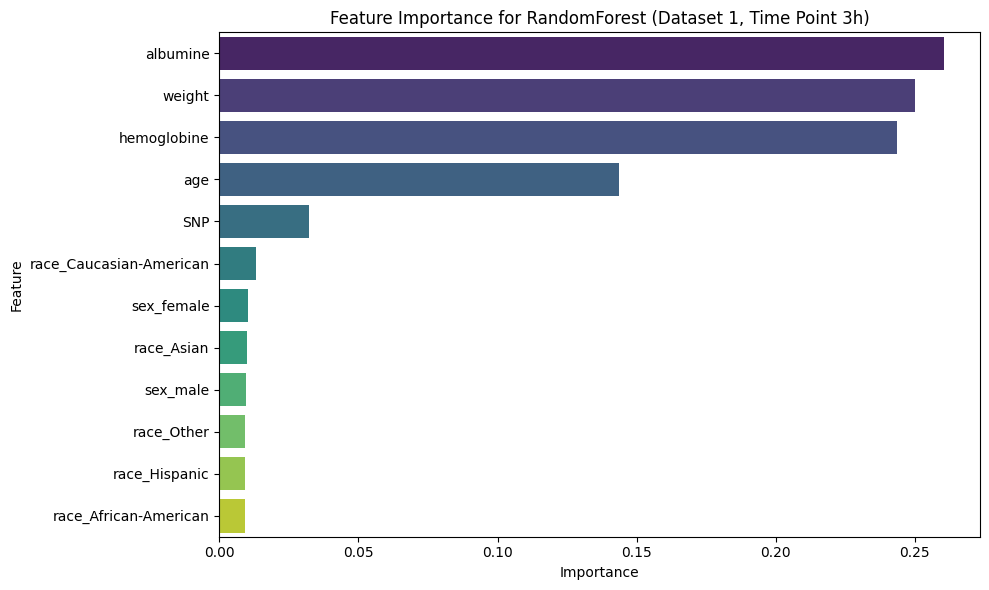

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


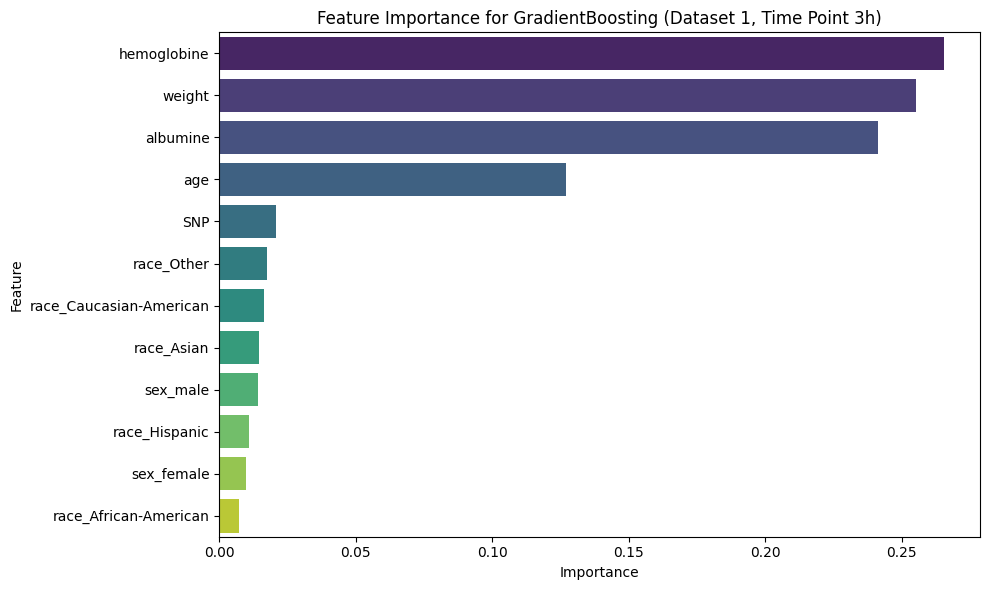


Visualizing Feature Importance for Dataset 2, Time Point 3h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


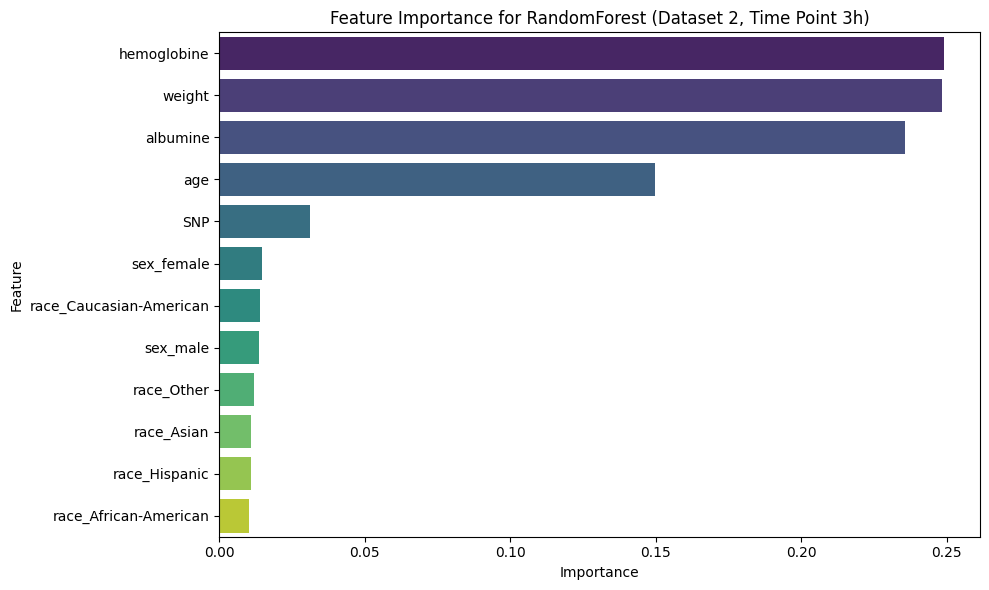

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


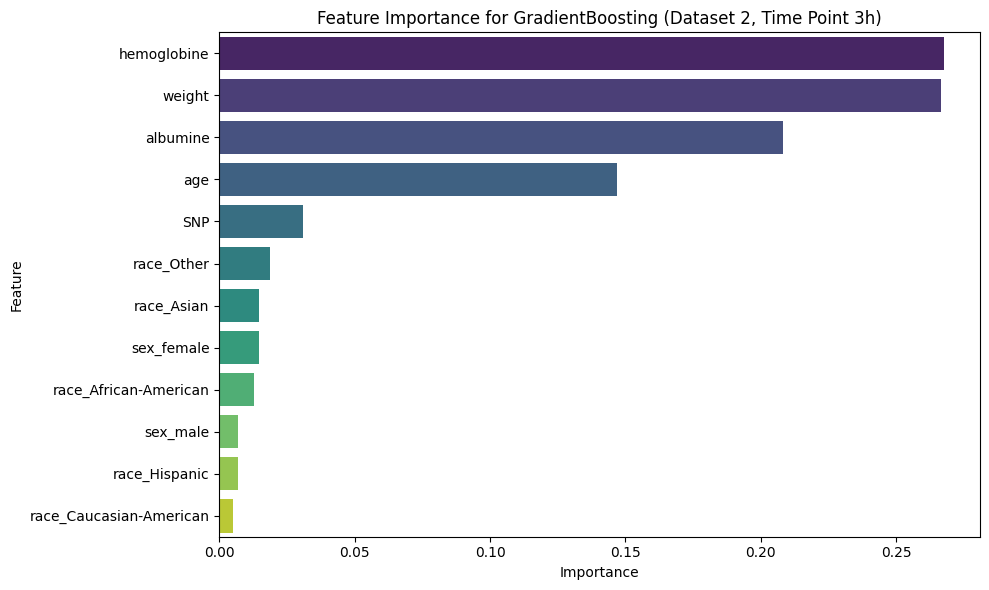


Visualizing Feature Importance for Dataset 1, Time Point 5h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


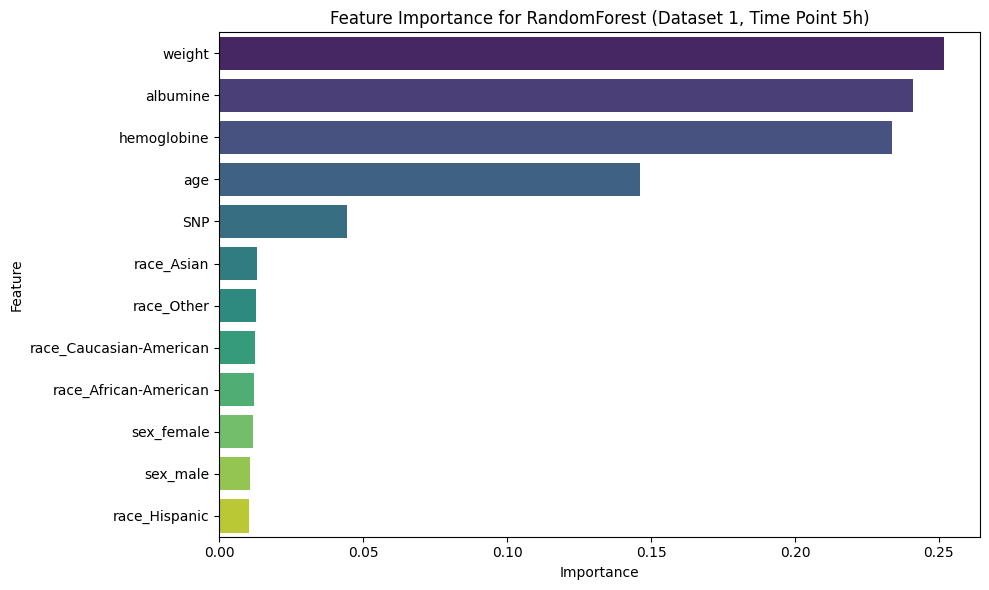

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


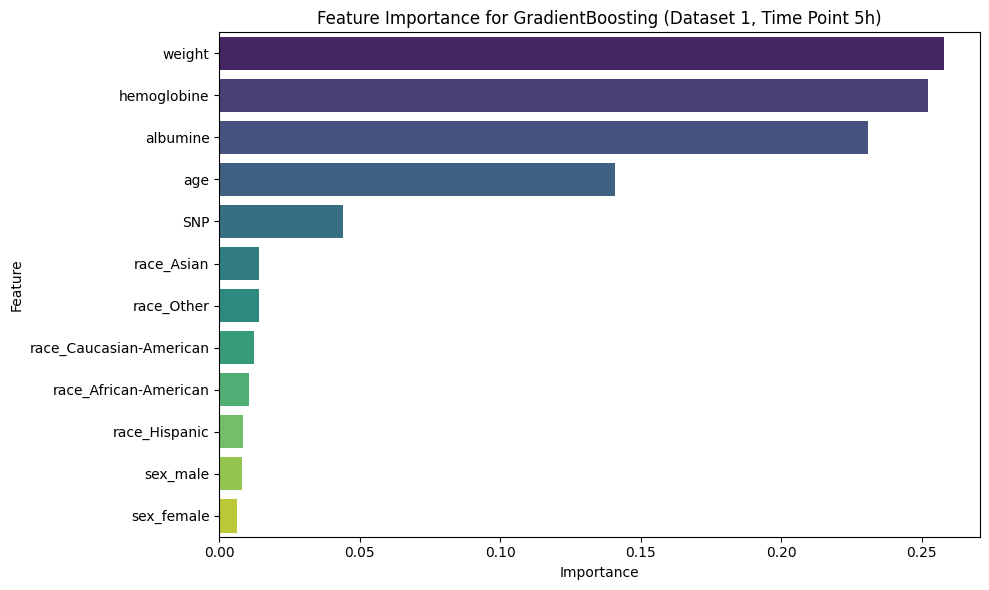


Visualizing Feature Importance for Dataset 2, Time Point 5h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


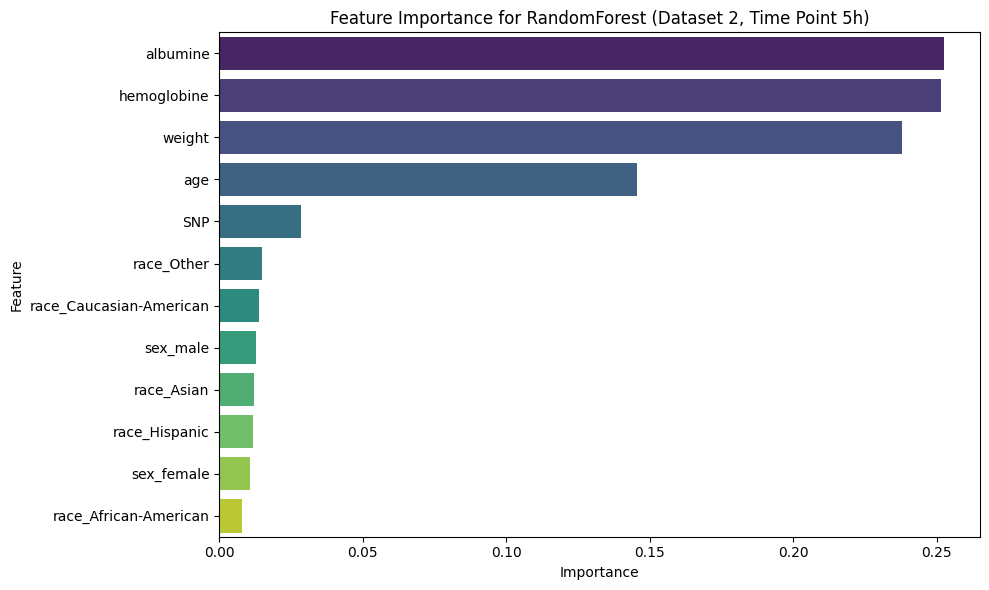

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


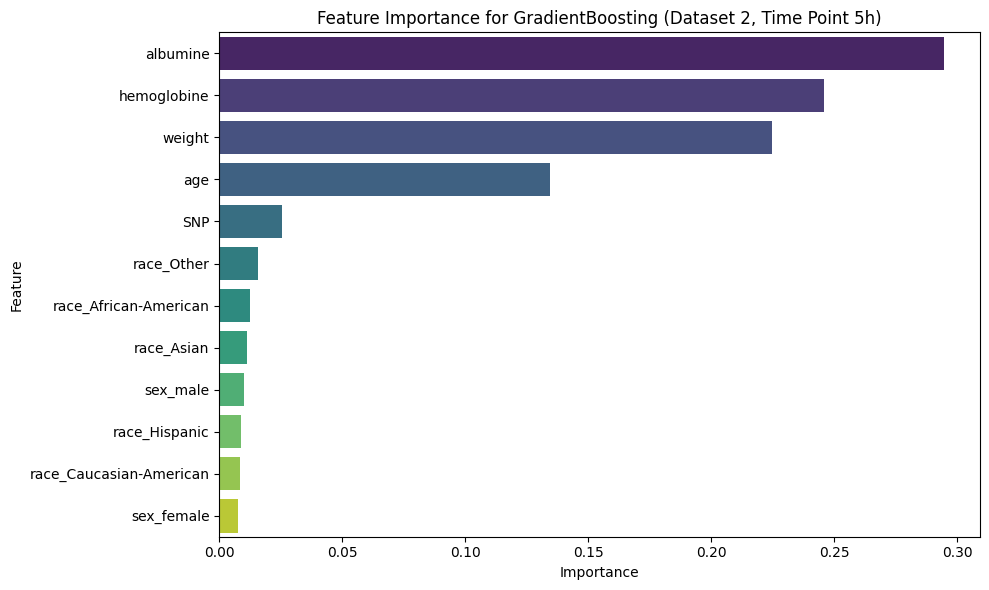


Visualizing Feature Importance for Dataset 1, Time Point 10h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


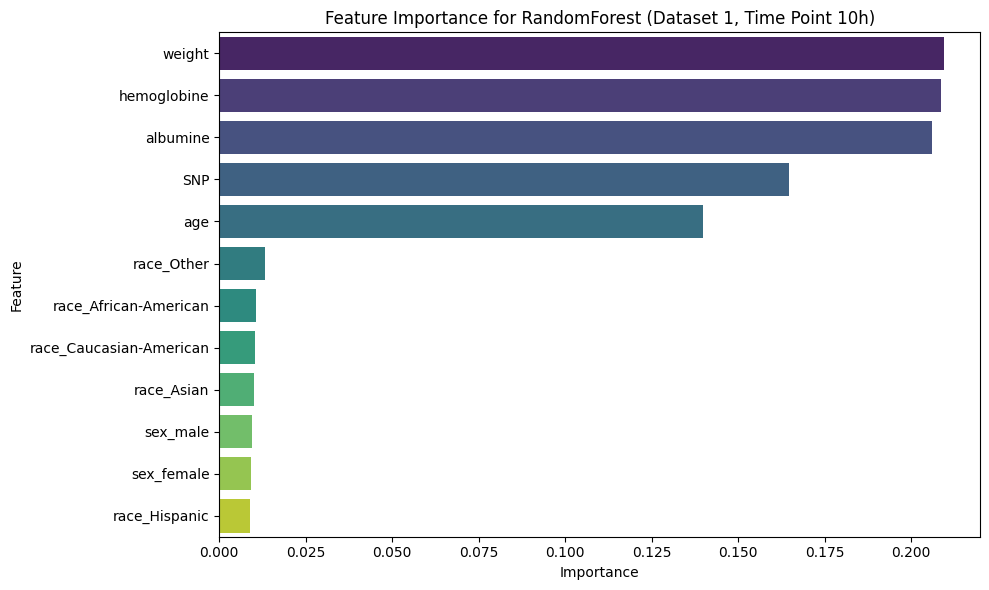

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


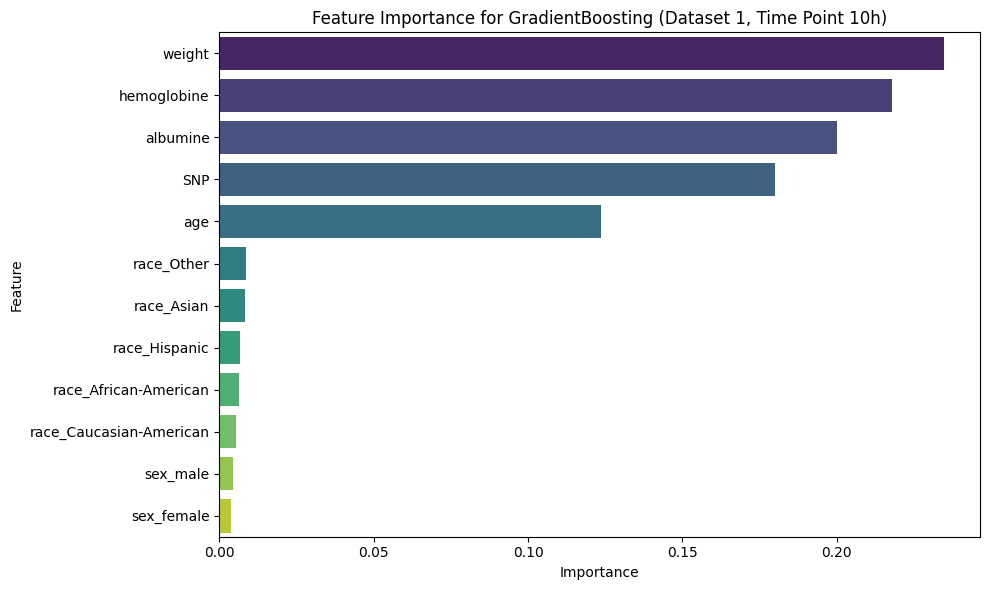


Visualizing Feature Importance for Dataset 2, Time Point 10h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


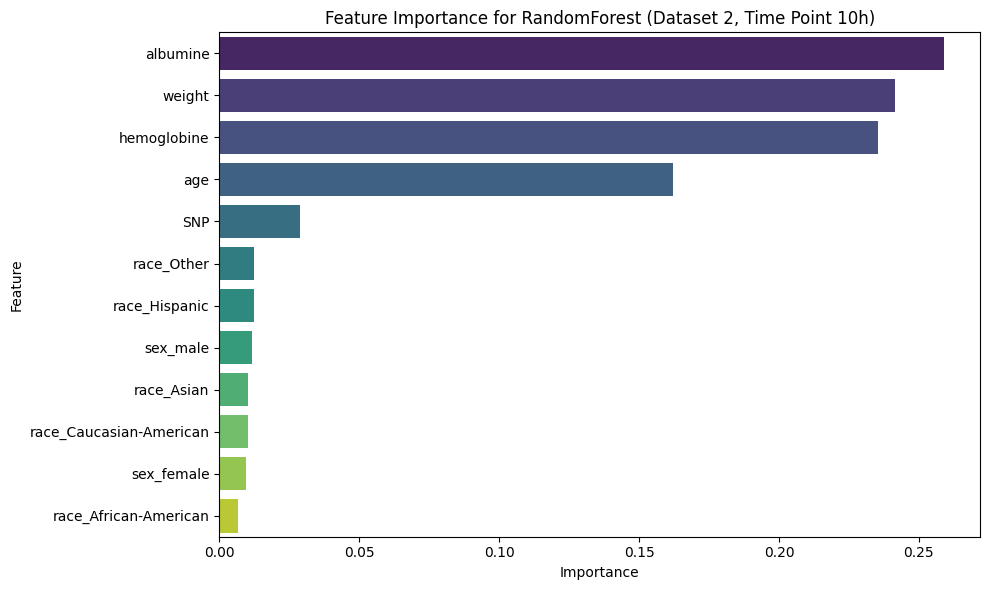

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


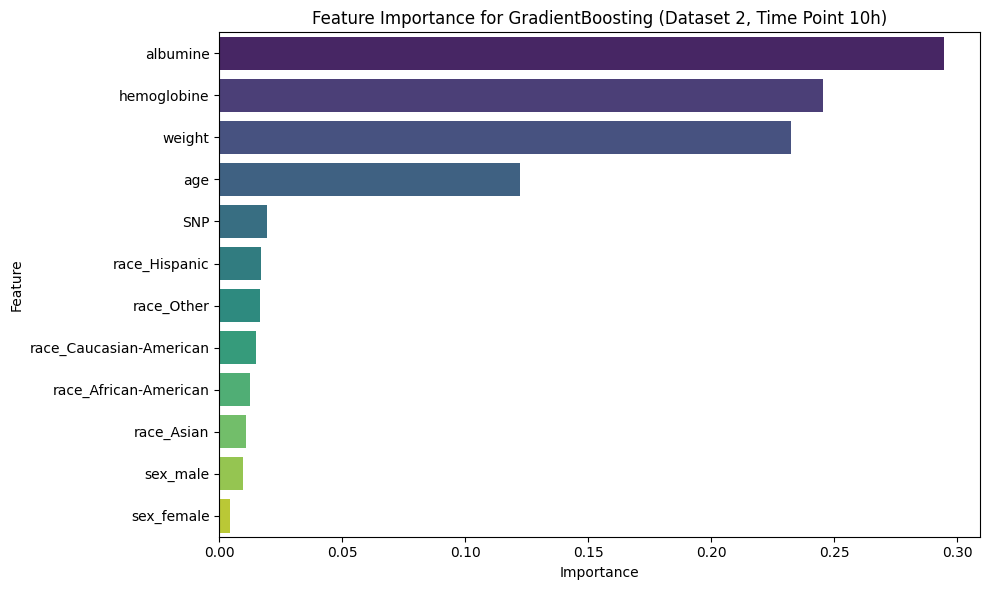


Visualizing Feature Importance for Dataset 1, Time Point 24h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


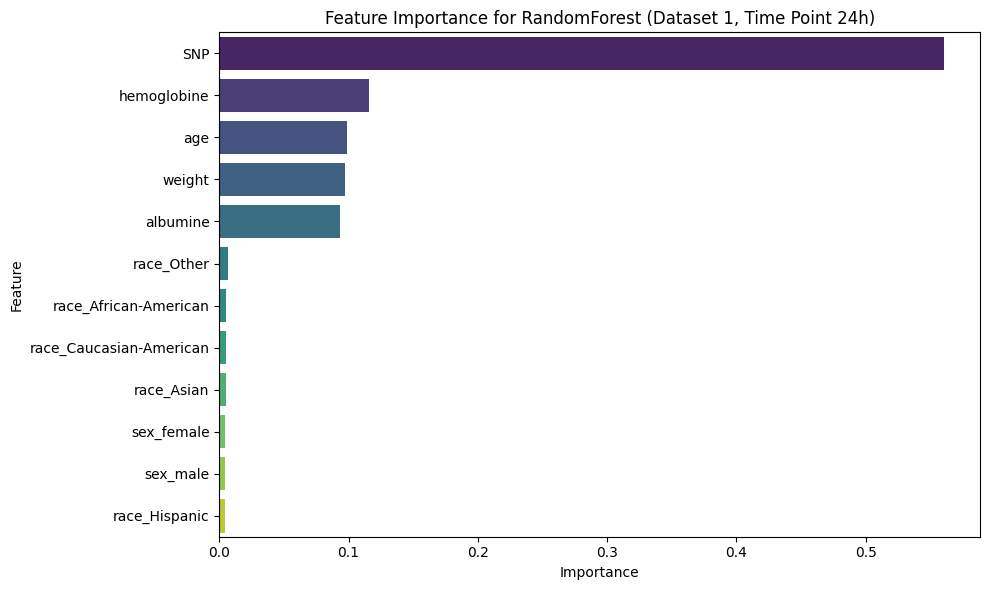

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


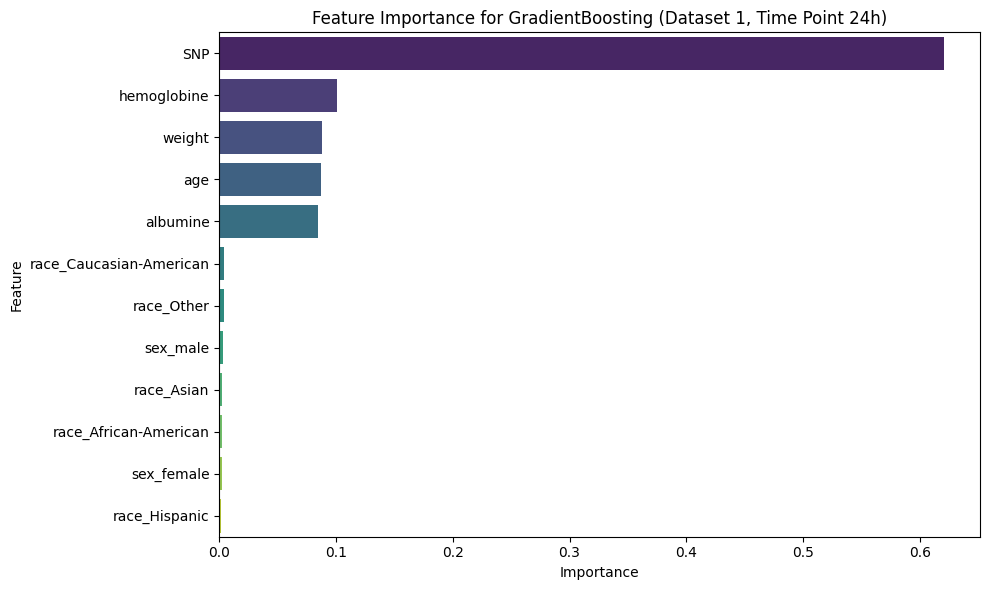


Visualizing Feature Importance for Dataset 2, Time Point 24h


<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


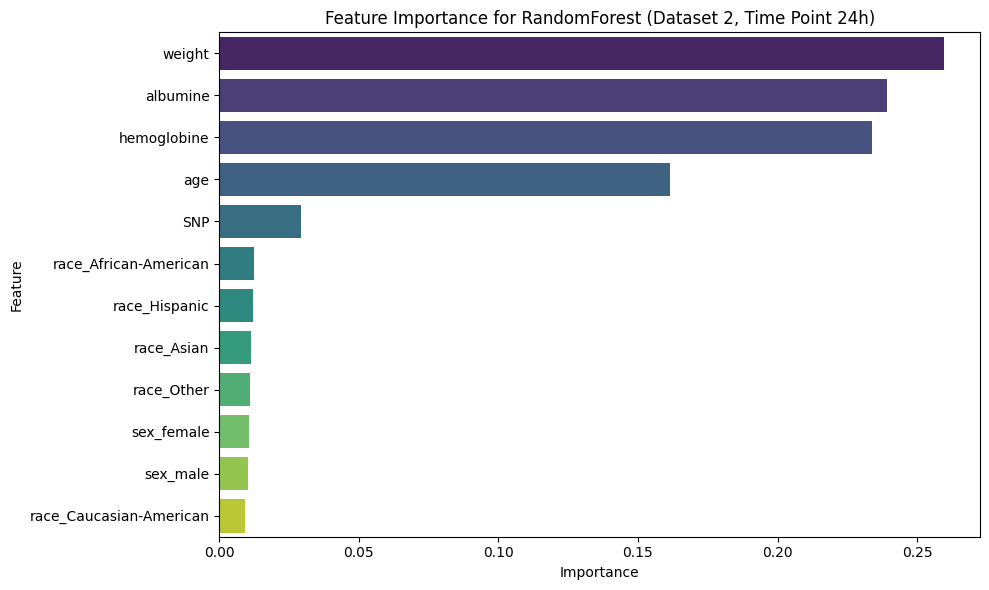

<ipython-input-7-acf597963c7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


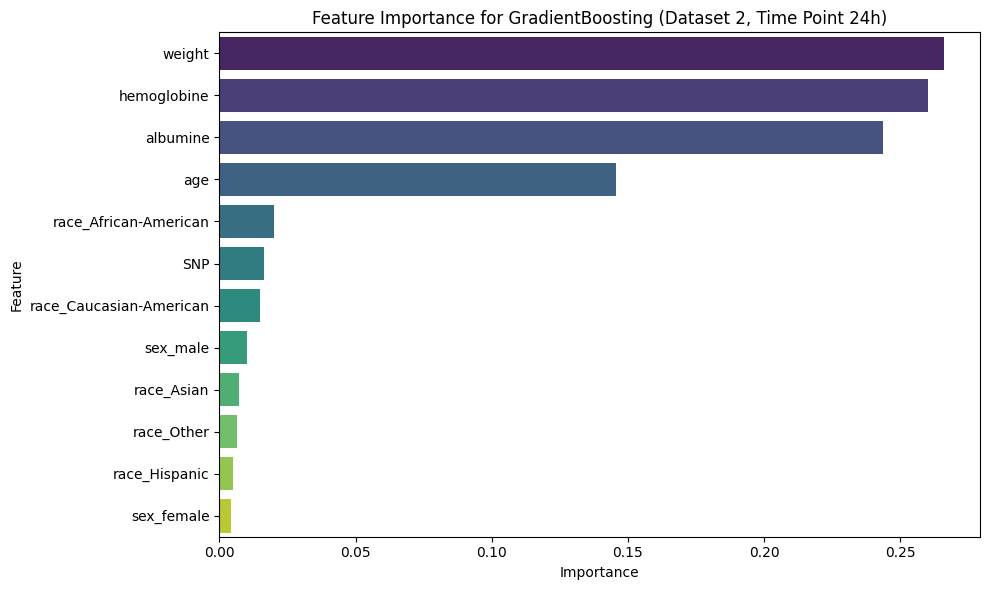

In [ ]:
# Function to visualize feature importance
def visualize_feature_importance(results, dataset_name, time_point):
    """
    Create bar plots for feature importance.

    Parameters:
    - results: Dictionary containing model results and feature importance
    - dataset_name: Name of the dataset (e.g., Dataset 1 or Dataset 2)
    - time_point: Time point being analyzed
    """
    for model_name, model_results in results.items():
        feature_importance = model_results['feature_importance']
        feature_importance_df = pd.DataFrame({
            'Feature': feature_importance.keys(),
            'Importance': feature_importance.values()
        }).sort_values(by='Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Feature Importance for {model_name} ({dataset_name}, Time Point {time_point}h)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

# Function to perform statistical validation
def validate_statistical_dependencies(cov_data_processed, pk_parameters, dataset_name):
    """
    Perform Pearson and Spearman correlation analyses for CL and ke with covariates.

    Parameters:
    - cov_data_processed: DataFrame containing processed covariates
    - pk_parameters: DataFrame containing CL and ke values
    - dataset_name: Name of the dataset (e.g., Dataset 1 or Dataset 2)
    """
    print(f"\nStatistical Validation for {dataset_name}:")
    covariates = ['age', 'weight', 'SNP', 'hemoglobine', 'albumine']

    for param in ['CL', 'ke']:
        print(f"\n{param} Dependency Analysis:")
        for cov in covariates:
            corr_pearson, p_value_pearson = pearsonr(cov_data_processed[cov], pk_parameters[param])
            corr_spearman, p_value_spearman = spearmanr(cov_data_processed[cov], pk_parameters[param])

            print(f"{param} - {cov}: Pearson: {corr_pearson:.3f} (p={p_value_pearson:.3f}), Spearman: {corr_spearman:.3f} (p={p_value_spearman:.3f})")

# Visualize feature importance for Dataset 1 and Dataset 2
for t in time_points:
    print(f"\nVisualizing Feature Importance for Dataset 1, Time Point {t}h")
    visualize_feature_importance(results_dataset1[t], "Dataset 1", t)

    print(f"\nVisualizing Feature Importance for Dataset 2, Time Point {t}h")
    visualize_feature_importance(results_dataset2[t], "Dataset 2", t)


In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler

def train_linear_models(conc_data, cov_data_processed, time_point):
    """
    Train and evaluate three different linear models with regularization:
    1. Lasso: Uses L1 regularization for feature selection
    2. Ridge: Uses L2 regularization to handle multicollinearity
    3. ElasticNet: Combines both L1 and L2 regularization
    """
    # Prepare features
    feature_cols = ['age', 'weight', 'SNP', 'hemoglobine', 'albumine',
                   'sex_female', 'sex_male',
                   'race_African-American', 'race_Asian', 'race_Caucasian-American',
                   'race_Hispanic', 'race_Other']

    X = cov_data_processed[feature_cols]
    y = conc_data[f't{time_point}']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models with cross-validation
    models = {
        'Lasso': LassoCV(cv=5, random_state=42, max_iter=2000),
        'Ridge': RidgeCV(cv=5, alphas=[0.1, 1.0, 10.0]),
        'ElasticNet': ElasticNetCV(cv=5, random_state=42, max_iter=2000)
    }

    results = {}

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Get feature importance (coefficients)
        coef = model.coef_ if hasattr(model, 'coef_') else np.zeros(len(feature_cols))
        importance = dict(zip(feature_cols, np.abs(coef)))

        results[name] = {
            'r2': r2,
            'rmse': rmse,
            'feature_importance': importance,
            'model': model
        }

    return results

# Run analysis for all time points
print("Training linear models for Dataset 1...")
linear_results1 = {t: train_linear_models(conc_data1, cov_processed1, t)
                  for t in time_points}

print("\nTraining linear models for Dataset 2...")
linear_results2 = {t: train_linear_models(conc_data2, cov_processed2, t)
                  for t in time_points}

# Print results
for dataset_num, results in [(1, linear_results1), (2, linear_results2)]:
    print(f"\nDataset {dataset_num} Linear Model Results:")
    for t in time_points:
        print(f"\nTime point {t}h:")
        for model_name, result in results[t].items():
            print(f"{model_name}:")
            print(f"  R² Score: {result['r2']:.3f}")
            print(f"  RMSE: {result['rmse']:.4f}")

            # Print top 3 features
            importance = result['feature_importance']
            top_features = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)[:3])
            print("  Top 3 features:")
            for feat, imp in top_features.items():
                print(f"    {feat}: {imp:.3f}")

Training linear models for Dataset 1...

Training linear models for Dataset 2...

Dataset 1 Linear Model Results:

Time point 2h:
Lasso:
  R² Score: 0.001
  RMSE: 0.0564
  Top 3 features:
    age: 0.001
    SNP: 0.000
    weight: 0.000
Ridge:
  R² Score: 0.001
  RMSE: 0.0564
  Top 3 features:
    age: 0.001
    SNP: 0.001
    race_Asian: 0.001
ElasticNet:
  R² Score: 0.001
  RMSE: 0.0564
  Top 3 features:
    age: 0.001
    SNP: 0.000
    weight: 0.000

Time point 3h:
Lasso:
  R² Score: 0.002
  RMSE: 0.0555
  Top 3 features:
    SNP: 0.002
    age: 0.001
    weight: 0.000
Ridge:
  R² Score: 0.002
  RMSE: 0.0555
  Top 3 features:
    SNP: 0.002
    age: 0.002
    race_Asian: 0.001
ElasticNet:
  R² Score: 0.002
  RMSE: 0.0555
  Top 3 features:
    SNP: 0.002
    age: 0.001
    weight: 0.000

Time point 5h:
Lasso:
  R² Score: 0.006
  RMSE: 0.0472
  Top 3 features:
    SNP: 0.004
    age: 0.002
    hemoglobine: 0.000
Ridge:
  R² Score: 0.006
  RMSE: 0.0473
  Top 3 features:
    SNP: 0.005


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

def create_neural_network_model(input_dim):
    """
    Creates a neural network specifically designed for pharmacokinetic modeling.
    The architecture uses multiple dense layers with dropout to prevent overfitting
    and batch normalization to handle the varying scales of drug concentrations.
    """
    model = Sequential([
        # Input layer with batch normalization to handle varying scales
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.2),  # Reduces overfitting

        # Hidden layers with decreasing size to capture complex relationships
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer for concentration prediction
        Dense(1, activation='linear')  # Linear activation for regression
    ])

    # Use Adam optimizer with a learning rate suitable for PK data
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae', 'mse'])
    return model

def train_neural_network(conc_data, cov_data_processed, time_point):
    """
    Trains a neural network to predict drug concentrations at a specific time point.
    Includes proper data preparation and model evaluation.
    """
    # Prepare features
    feature_cols = ['age', 'weight', 'SNP', 'hemoglobine', 'albumine',
                   'sex_female', 'sex_male',
                   'race_African-American', 'race_Asian', 'race_Caucasian-American',
                   'race_Hispanic', 'race_Other']

    X = cov_data_processed[feature_cols]
    y = conc_data[f't{time_point}']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train model
    model = create_neural_network_model(X_train.shape[1])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Make predictions
    y_pred = model.predict(X_test_scaled, verbose=0)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate feature importance using permutation importance
    feature_importance = {}
    baseline_score = r2_score(y_test, model.predict(X_test_scaled, verbose=0))

    for feature in range(X_test_scaled.shape[1]):
        # Create a copy and shuffle one feature
        X_temp = X_test_scaled.copy()
        X_temp[:, feature] = np.random.permutation(X_temp[:, feature])

        # Calculate importance as the drop in R²
        new_score = r2_score(y_test, model.predict(X_temp, verbose=0))
        importance = baseline_score - new_score
        feature_importance[feature_cols[feature]] = abs(importance)

    # Normalize feature importance
    total_importance = sum(feature_importance.values())
    if total_importance > 0:
        feature_importance = {k: v/total_importance for k, v in feature_importance.items()}

    return {
        'r2': r2,
        'rmse': rmse,
        'feature_importance': feature_importance,
        'model': model,
        'history': history
    }

# Run analysis for both datasets
print("Training neural networks for Dataset 1...")
nn_results1 = {t: train_neural_network(conc_data1, cov_processed1, t)
               for t in time_points}

print("\nTraining neural networks for Dataset 2...")
nn_results2 = {t: train_neural_network(conc_data2, cov_processed2, t)
               for t in time_points}

# Print results
for dataset_num, results in [(1, nn_results1), (2, nn_results2)]:
    print(f"\nDataset {dataset_num} Neural Network Results:")
    for t in time_points:
        print(f"\nTime point {t}h:")
        print(f"R² Score: {results[t]['r2']:.3f}")
        print(f"RMSE: {results[t]['rmse']:.4f}")

        # Print top 3 features
        importance = results[t]['feature_importance']
        top_features = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)[:3])
        print("Top 3 features:")
        for feat, imp in top_features.items():
            print(f"  {feat}: {imp:.3f}")

Training neural networks for Dataset 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo


Training neural networks for Dataset 2...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo


Dataset 1 Neural Network Results:

Time point 2h:
R² Score: -0.002
RMSE: 0.0565
Top 3 features:
  age: 0.224
  race_African-American: 0.182
  race_Caucasian-American: 0.182

Time point 3h:
R² Score: -0.006
RMSE: 0.0557
Top 3 features:
  race_African-American: 0.178
  race_Hispanic: 0.164
  weight: 0.145

Time point 5h:
R² Score: 0.001
RMSE: 0.0474
Top 3 features:
  SNP: 0.215
  hemoglobine: 0.145
  sex_male: 0.126

Time point 10h:
R² Score: 0.015
RMSE: 0.0322
Top 3 features:
  SNP: 0.381
  race_African-American: 0.207
  age: 0.116

Time point 24h:
R² Score: 0.093
RMSE: 0.0168
Top 3 features:
  SNP: 0.696
  hemoglobine: 0.094
  sex_male: 0.082

Dataset 2 Neural Network Results:

Time point 2h:
R² Score: -0.016
RMSE: 0.0531
Top 3 features:
  hemoglobine: 0.165
  race_Hispanic: 0.152
  sex_female: 0.149

Time point 3h:
R² Score: -0.003
RMSE: 0.0476
Top 3 features:
  weight: 0.277
  race_Hispanic: 0.194
  race_Other: 0.152

Time point 5h:
R² Score: -0.001
RMSE: 0.0373
Top 3 features:
  ra

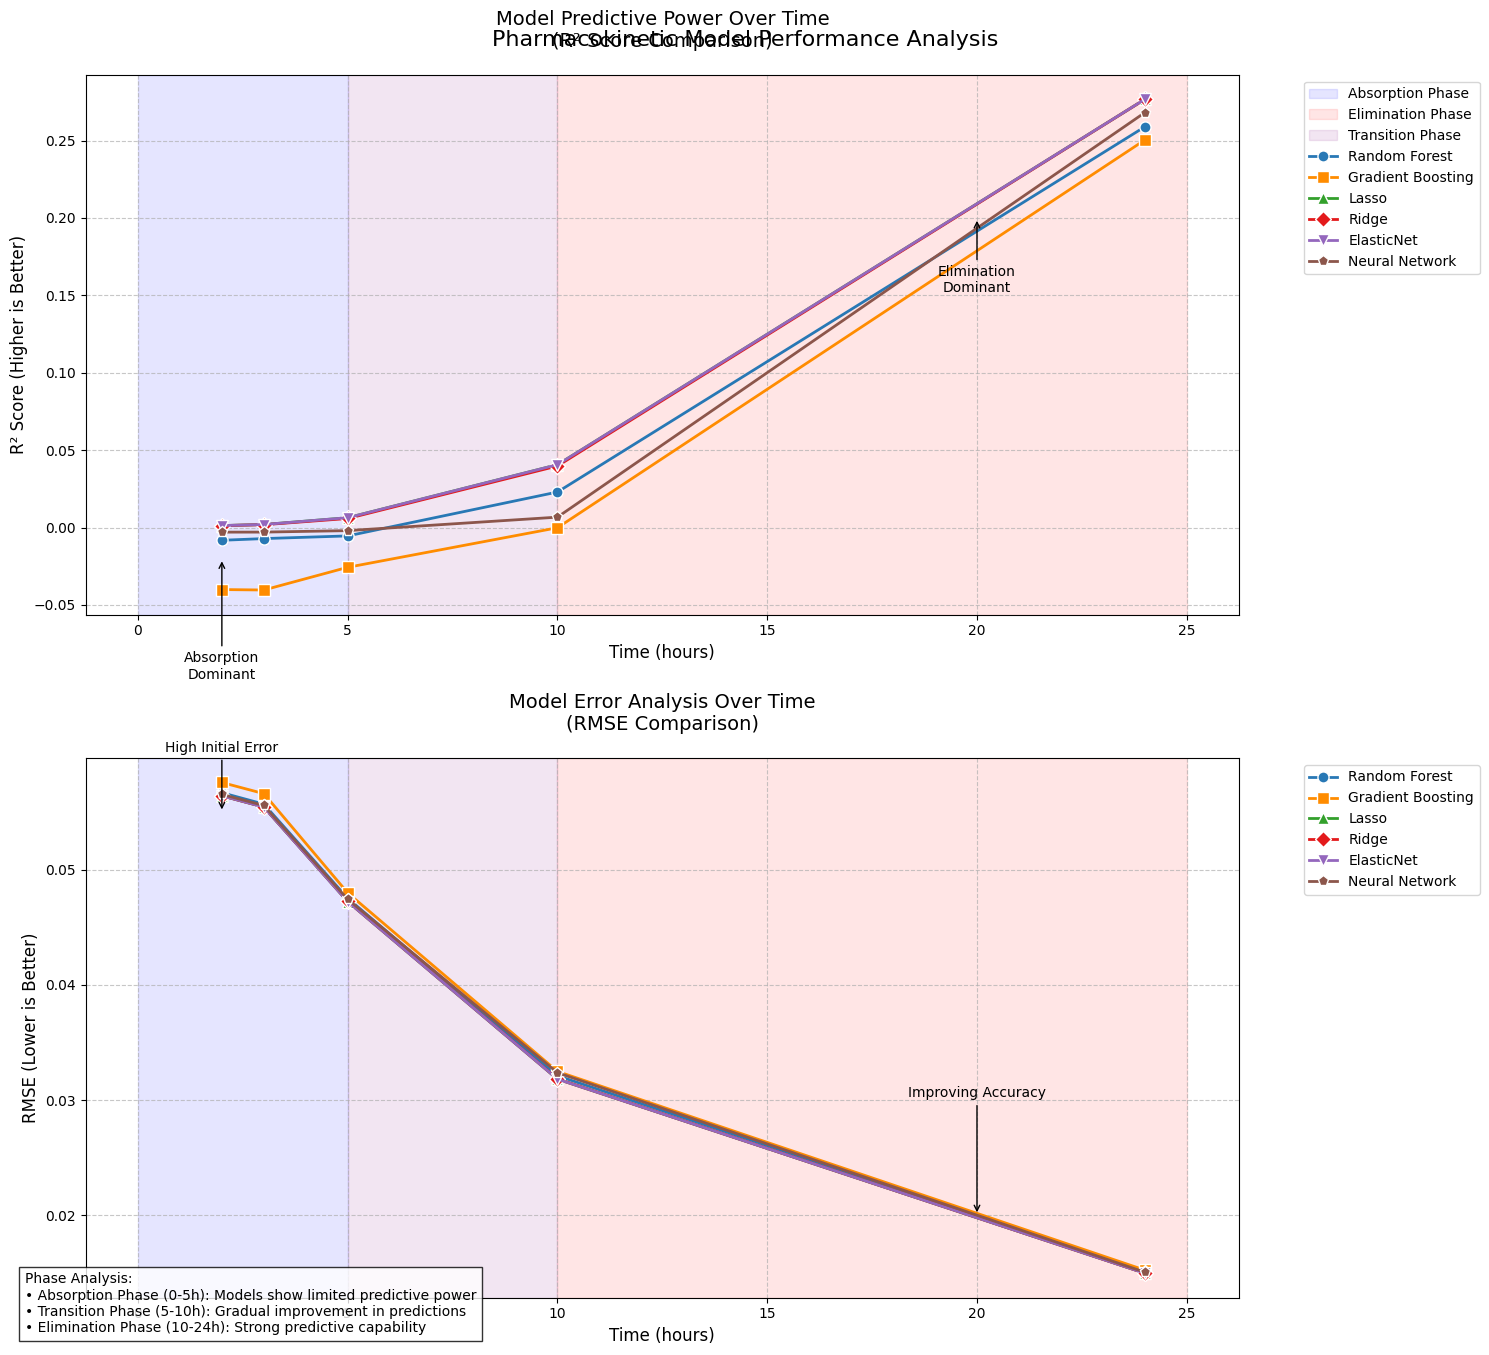

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_enhanced_visualization(df_results):
    """
    Creates an enhanced visualization comparing model performances with improved readability
    and additional analytical features.
    """
    # Set up figure with increased size and better spacing
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))
    fig.suptitle('Pharmacokinetic Model Performance Analysis',
                fontsize=16, y=0.95)

    # Define professional color scheme and markers
    colors = ['#2878B5', '#FF8C00', '#33A02C', '#E31A1C', '#9467BD', '#8C564B']
    markers = ['o', 's', '^', 'D', 'v', 'p']

    # Add shaded regions to represent different pharmacokinetic phases
    absorption_end = 5
    elimination_start = 10

    # Plot R² scores with enhanced features
    ax1.axvspan(0, absorption_end, alpha=0.1, color='blue', label='Absorption Phase')
    ax1.axvspan(elimination_start, 25, alpha=0.1, color='red', label='Elimination Phase')
    ax1.axvspan(absorption_end, elimination_start, alpha=0.1, color='purple', label='Transition Phase')

    for idx, model in enumerate(df_results['Model'].unique()):
        model_data = df_results[df_results['Model'] == model]
        ax1.plot(model_data['Time'], model_data['R2'],
                marker=markers[idx], label=model, color=colors[idx],
                linewidth=2, markersize=8, markeredgewidth=1,
                markeredgecolor='white')

    ax1.set_title('Model Predictive Power Over Time\n(R² Score Comparison)',
                 fontsize=14, pad=20)
    ax1.set_xlabel('Time (hours)', fontsize=12)
    ax1.set_ylabel('R² Score (Higher is Better)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    # Add annotations for key points
    ax1.annotate('Absorption\nDominant', xy=(2, -0.02), xytext=(2, -0.08),
                ha='center', va='top', fontsize=10,
                arrowprops=dict(arrowstyle='->'))
    ax1.annotate('Elimination\nDominant', xy=(20, 0.2), xytext=(20, 0.15),
                ha='center', va='bottom', fontsize=10,
                arrowprops=dict(arrowstyle='->'))

    # Plot RMSE with enhanced features
    ax2.axvspan(0, absorption_end, alpha=0.1, color='blue')
    ax2.axvspan(elimination_start, 25, alpha=0.1, color='red')
    ax2.axvspan(absorption_end, elimination_start, alpha=0.1, color='purple')

    for idx, model in enumerate(df_results['Model'].unique()):
        model_data = df_results[df_results['Model'] == model]
        ax2.plot(model_data['Time'], model_data['RMSE'],
                marker=markers[idx], label=model, color=colors[idx],
                linewidth=2, markersize=8, markeredgewidth=1,
                markeredgecolor='white')

    ax2.set_title('Model Error Analysis Over Time\n(RMSE Comparison)',
                 fontsize=14, pad=20)
    ax2.set_xlabel('Time (hours)', fontsize=12)
    ax2.set_ylabel('RMSE (Lower is Better)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    # Add annotations for error trends
    ax2.annotate('High Initial Error', xy=(2, 0.055), xytext=(2, 0.06),
                ha='center', va='bottom', fontsize=10,
                arrowprops=dict(arrowstyle='->'))
    ax2.annotate('Improving Accuracy', xy=(20, 0.02), xytext=(20, 0.03),
                ha='center', va='bottom', fontsize=10,
                arrowprops=dict(arrowstyle='->'))

    # Add explanatory text box
    fig.text(0.02, 0.02,
             'Phase Analysis:\n' +
             '• Absorption Phase (0-5h): Models show limited predictive power\n' +
             '• Transition Phase (5-10h): Gradual improvement in predictions\n' +
             '• Elimination Phase (10-24h): Strong predictive capability',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

# Create and display the enhanced visualization
fig = create_enhanced_visualization(df_results)
plt.show()

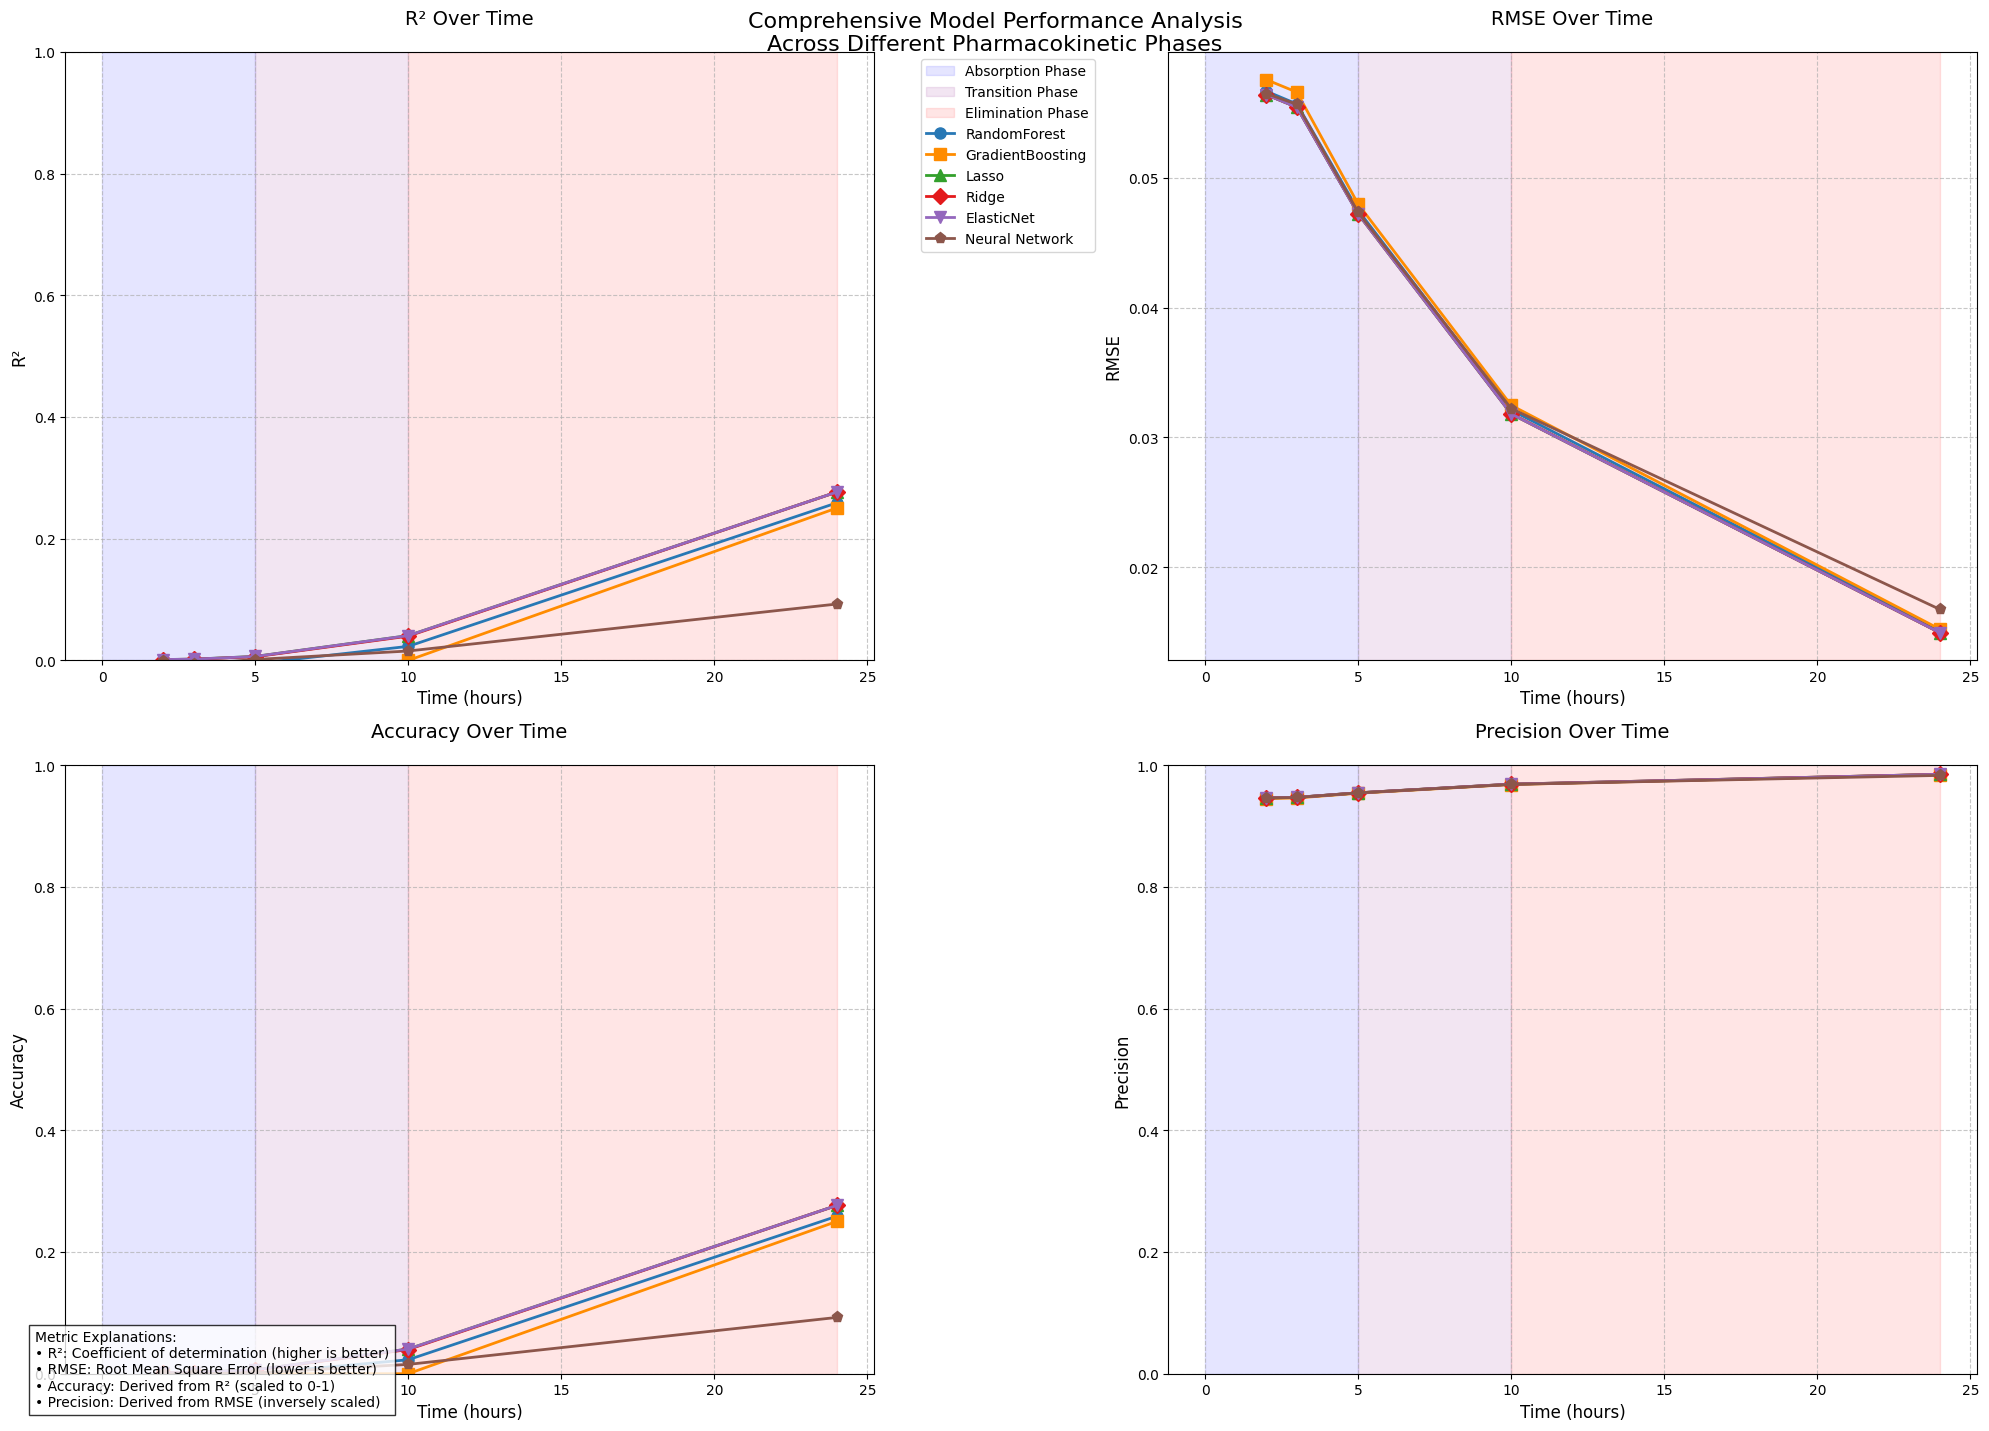

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def prepare_performance_data(results_dataset1, linear_results1, nn_results1):
    """
    Organizes performance metrics from all models into a structured format for visualization.
    We'll use R² scores and RMSE values, then derive additional metrics from these.
    """
    time_points = [2, 3, 5, 10, 24]
    metrics_data = []

    # Process results from each time point
    for t in time_points:
        # Gather metrics from tree-based models
        for model_name in ['RandomForest', 'GradientBoosting']:
            metrics_data.append({
                'Time': t,
                'Model': model_name,
                'R²': results_dataset1[t][model_name]['r2'],
                'RMSE': results_dataset1[t][model_name]['rmse'],
                # Convert R² to accuracy-like metric (scaled between 0 and 1)
                'Accuracy': max(0, results_dataset1[t][model_name]['r2']),
                # Calculate precision-like metric based on RMSE
                'Precision': 1 / (1 + results_dataset1[t][model_name]['rmse'])
            })

        # Process linear models
        for model_name in ['Lasso', 'Ridge', 'ElasticNet']:
            metrics_data.append({
                'Time': t,
                'Model': model_name,
                'R²': linear_results1[t][model_name]['r2'],
                'RMSE': linear_results1[t][model_name]['rmse'],
                'Accuracy': max(0, linear_results1[t][model_name]['r2']),
                'Precision': 1 / (1 + linear_results1[t][model_name]['rmse'])
            })

        # Process neural network results
        metrics_data.append({
            'Time': t,
            'Model': 'Neural Network',
            'R²': nn_results1[t]['r2'],
            'RMSE': nn_results1[t]['rmse'],
            'Accuracy': max(0, nn_results1[t]['r2']),
            'Precision': 1 / (1 + nn_results1[t]['rmse'])
        })

    return pd.DataFrame(metrics_data)

def create_performance_visualization(metrics_df):
    """
    Creates a comprehensive visualization comparing model performance across different metrics.
    This includes R², RMSE, and derived performance metrics to give a complete picture.
    """
    fig = plt.figure(figsize=(20, 15))

    # Define consistent styling elements
    colors = ['#2878B5', '#FF8C00', '#33A02C', '#E31A1C', '#9467BD', '#8C564B']
    markers = ['o', 's', '^', 'D', 'v', 'p']
    metrics = ['R²', 'RMSE', 'Accuracy', 'Precision']

    # Create subplots for each metric
    for idx, metric in enumerate(metrics, 1):
        ax = plt.subplot(2, 2, idx)

        # Add pharmacokinetic phase shading
        ax.axvspan(0, 5, alpha=0.1, color='blue', label='Absorption Phase' if idx == 1 else '')
        ax.axvspan(5, 10, alpha=0.1, color='purple', label='Transition Phase' if idx == 1 else '')
        ax.axvspan(10, 24, alpha=0.1, color='red', label='Elimination Phase' if idx == 1 else '')

        # Plot each model's performance
        for model_idx, model in enumerate(metrics_df['Model'].unique()):
            model_data = metrics_df[metrics_df['Model'] == model]
            ax.plot(model_data['Time'], model_data[metric],
                   marker=markers[model_idx],
                   label=model if idx == 1 else '',
                   color=colors[model_idx],
                   linewidth=2, markersize=8)

        # Customize subplot appearance
        ax.set_title(f'{metric} Over Time', fontsize=14, pad=20)
        ax.set_xlabel('Time (hours)', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

        # Set appropriate y-axis limits
        if metric != 'RMSE':
            ax.set_ylim(0, 1)

        # Add legend to first subplot only
        if idx == 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle('Comprehensive Model Performance Analysis\nAcross Different Pharmacokinetic Phases',
                fontsize=16, y=0.95)

    # Add explanatory text
    fig.text(0.02, 0.02,
             'Metric Explanations:\n' +
             '• R²: Coefficient of determination (higher is better)\n' +
             '• RMSE: Root Mean Square Error (lower is better)\n' +
             '• Accuracy: Derived from R² (scaled to 0-1)\n' +
             '• Precision: Derived from RMSE (inversely scaled)',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

# Generate and display the visualization
metrics_df = prepare_performance_data(results_dataset1, linear_results1, nn_results1)
fig = create_performance_visualization(metrics_df)
plt.show()

In [ ]:
# Correlation analysis
def perform_correlation_analysis(cov_data_processed, conc_data, params, dataset_name):
    print(f"\nCorrelation Analysis for {dataset_name}:")
    for param in params:
        for cov in ['age', 'weight', 'SNP', 'hemoglobine', 'albumine']:
            corr_pearson, p_value_pearson = pearsonr(cov_data_processed[cov], cov_data_processed[param])
            corr_spearman, p_value_spearman = spearmanr(cov_data_processed[cov], cov_data_processed[param])
            print(f"{param} - {cov}: Pearson: {corr_pearson:.3f} (p={p_value_pearson:.3f}), Spearman: {corr_spearman:.3f} (p={p_value_spearman:.3f})")

In [ ]:
# Perform correlation analysis for Dataset 1
perform_correlation_analysis(cov_processed1, conc_data1, ['CL', 'ke'], "Dataset 1")


Correlation Analysis for Dataset 1:
CL - age: Pearson: -0.239 (p=0.000), Spearman: -0.209 (p=0.000)
CL - weight: Pearson: 0.002 (p=0.816), Spearman: -0.002 (p=0.836)
CL - SNP: Pearson: 0.761 (p=0.000), Spearman: 0.822 (p=0.000)
CL - hemoglobine: Pearson: -0.126 (p=0.000), Spearman: -0.117 (p=0.000)
CL - albumine: Pearson: 0.078 (p=0.000), Spearman: 0.068 (p=0.000)
ke - age: Pearson: -0.093 (p=0.000), Spearman: -0.098 (p=0.000)
ke - weight: Pearson: 0.005 (p=0.607), Spearman: 0.005 (p=0.633)
ke - SNP: Pearson: 0.357 (p=0.000), Spearman: 0.424 (p=0.000)
ke - hemoglobine: Pearson: -0.068 (p=0.000), Spearman: -0.059 (p=0.000)
ke - albumine: Pearson: 0.035 (p=0.000), Spearman: 0.034 (p=0.001)


In [ ]:
# Perform correlation analysis for Dataset 2
perform_correlation_analysis(cov_processed2, conc_data2, ['CL', 'ke'], "Dataset 2")


Correlation Analysis for Dataset 2:
CL - age: Pearson: 0.004 (p=0.678), Spearman: 0.000 (p=0.963)
CL - weight: Pearson: 0.006 (p=0.529), Spearman: 0.006 (p=0.527)
CL - SNP: Pearson: -0.002 (p=0.842), Spearman: -0.002 (p=0.843)
CL - hemoglobine: Pearson: 0.005 (p=0.609), Spearman: 0.006 (p=0.542)
CL - albumine: Pearson: 0.015 (p=0.136), Spearman: 0.017 (p=0.086)
ke - age: Pearson: -0.005 (p=0.626), Spearman: -0.006 (p=0.577)
ke - weight: Pearson: 0.004 (p=0.658), Spearman: 0.003 (p=0.802)
ke - SNP: Pearson: 0.004 (p=0.722), Spearman: -0.005 (p=0.652)
ke - hemoglobine: Pearson: -0.002 (p=0.823), Spearman: 0.001 (p=0.912)
ke - albumine: Pearson: 0.005 (p=0.592), Spearman: 0.015 (p=0.147)


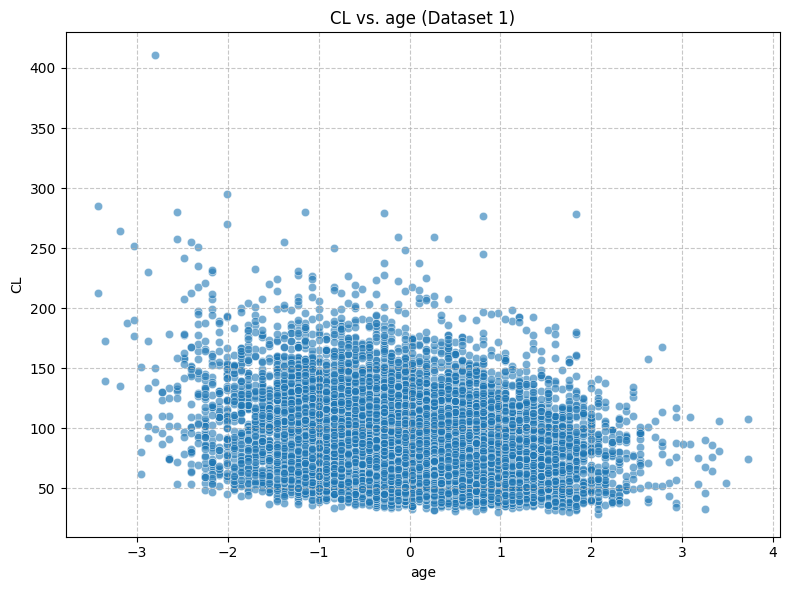

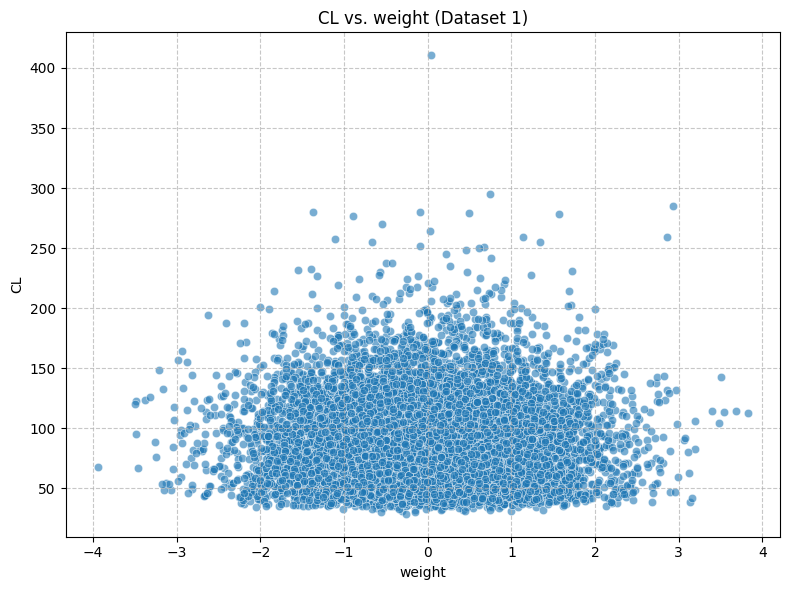

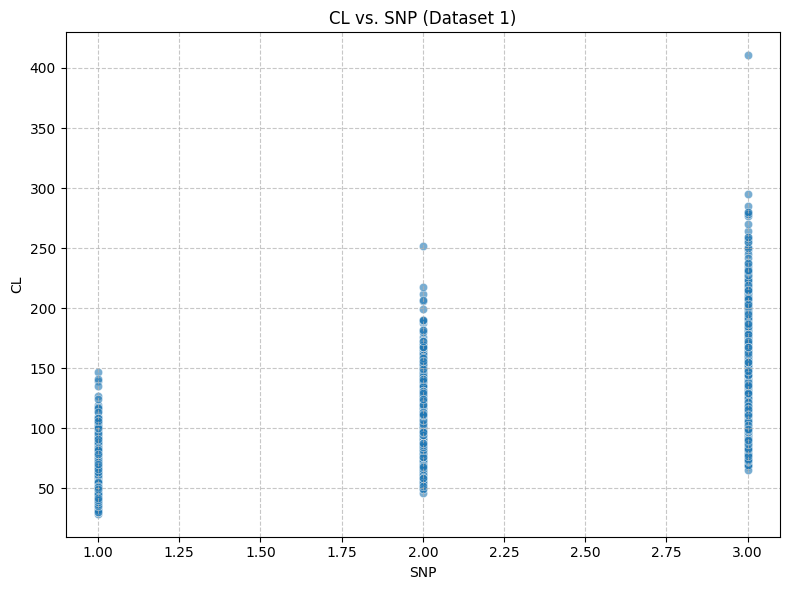

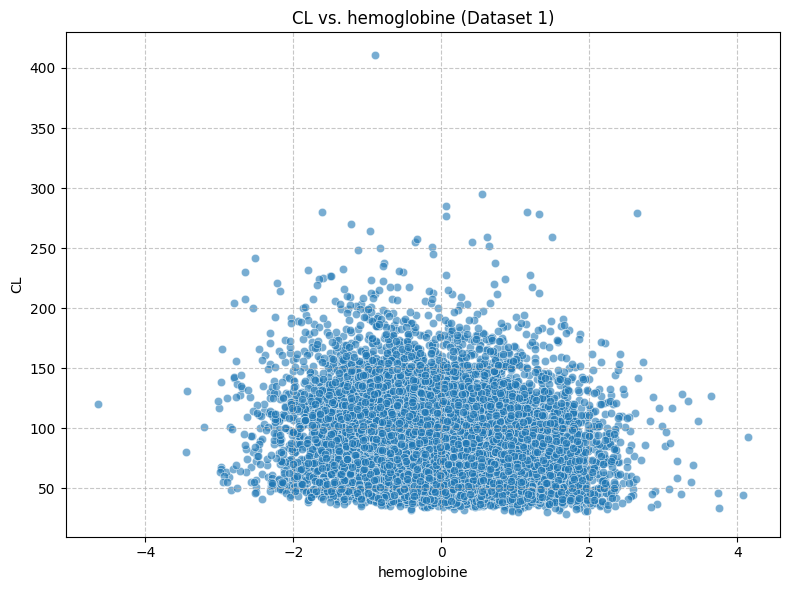

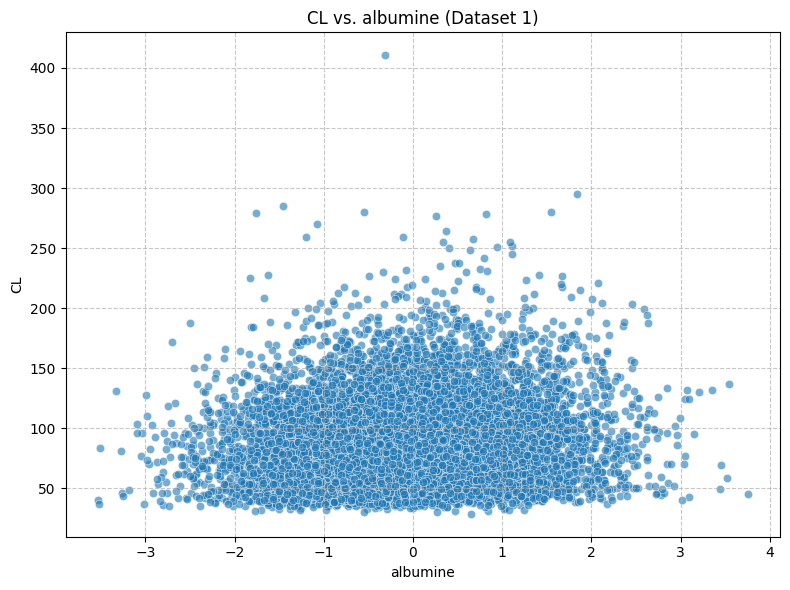

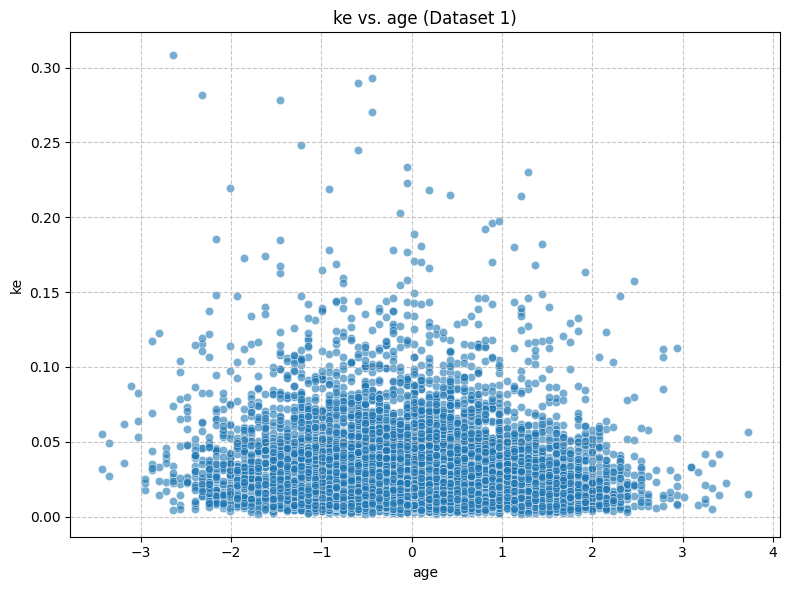

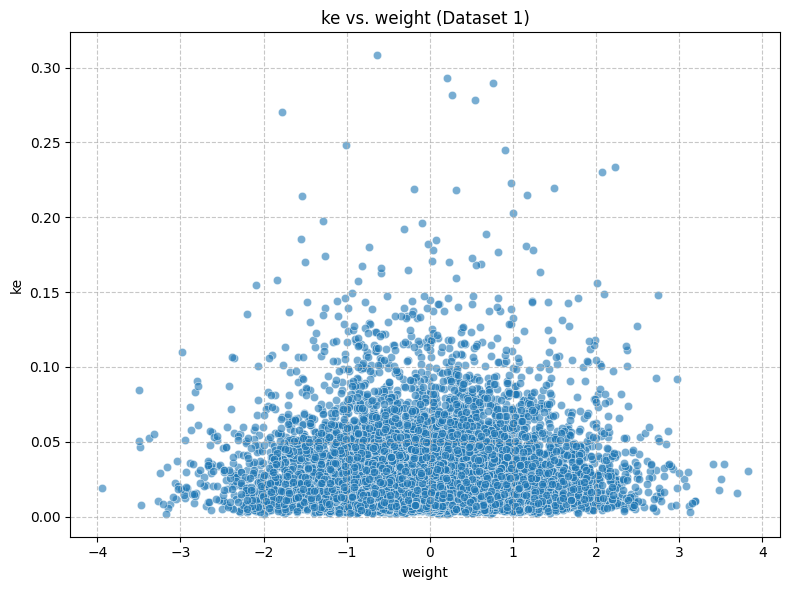

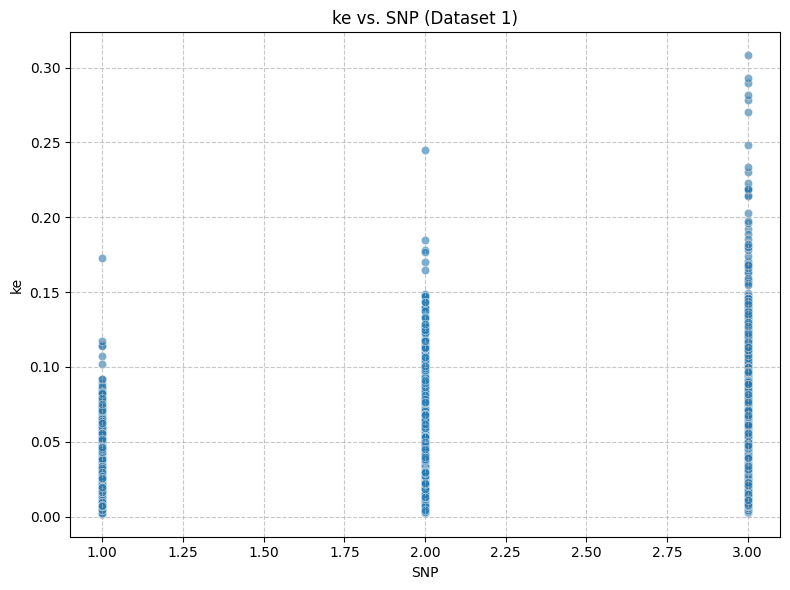

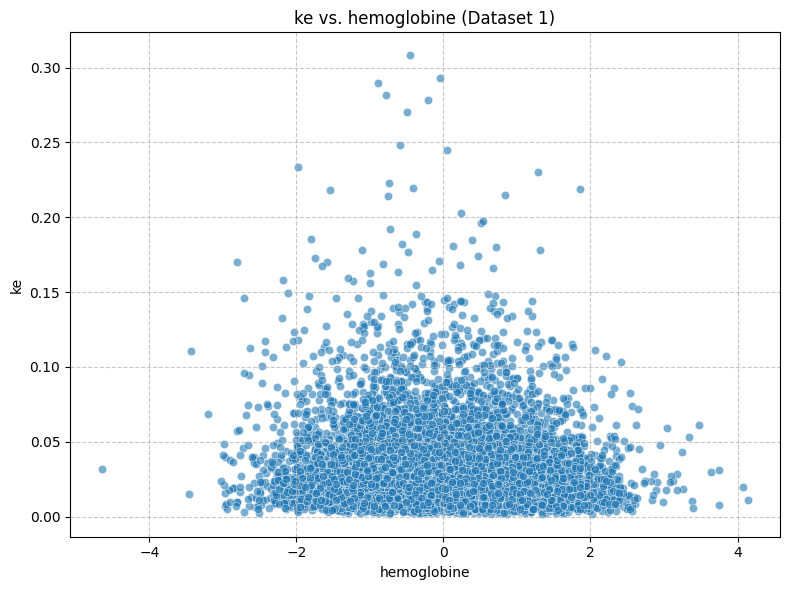

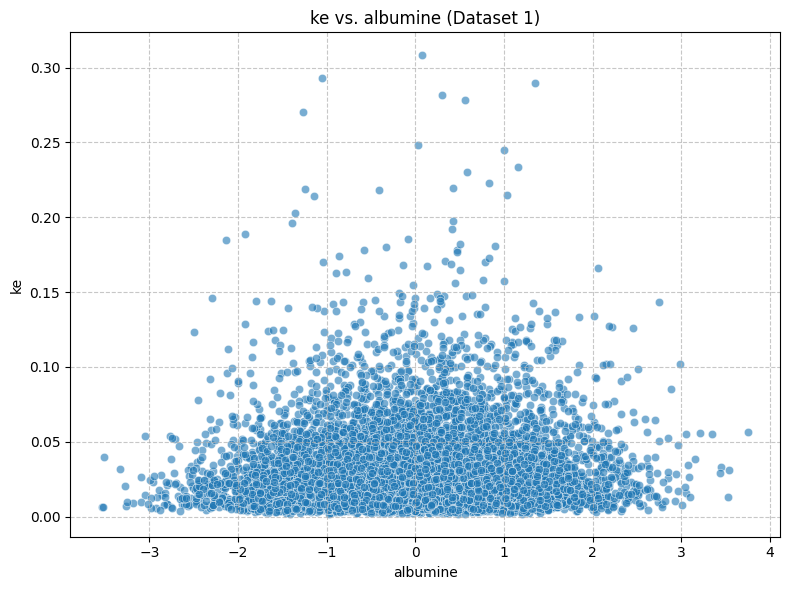

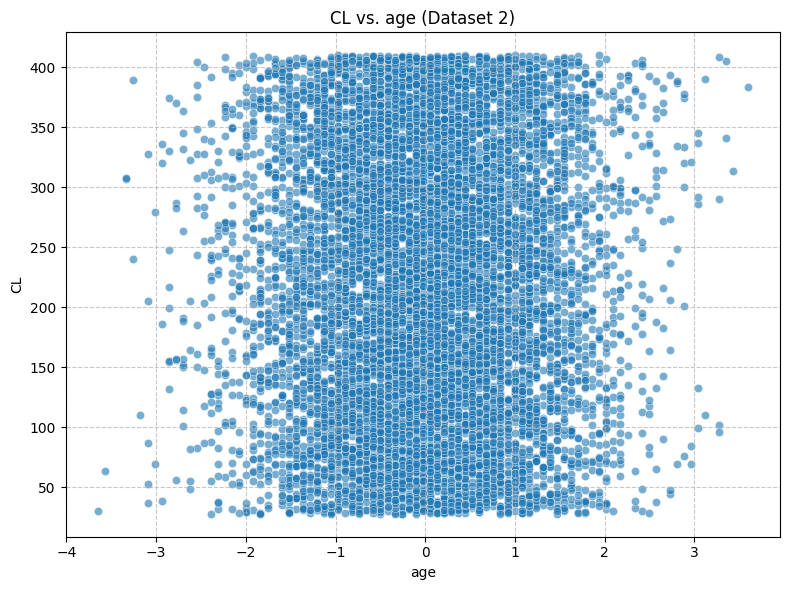

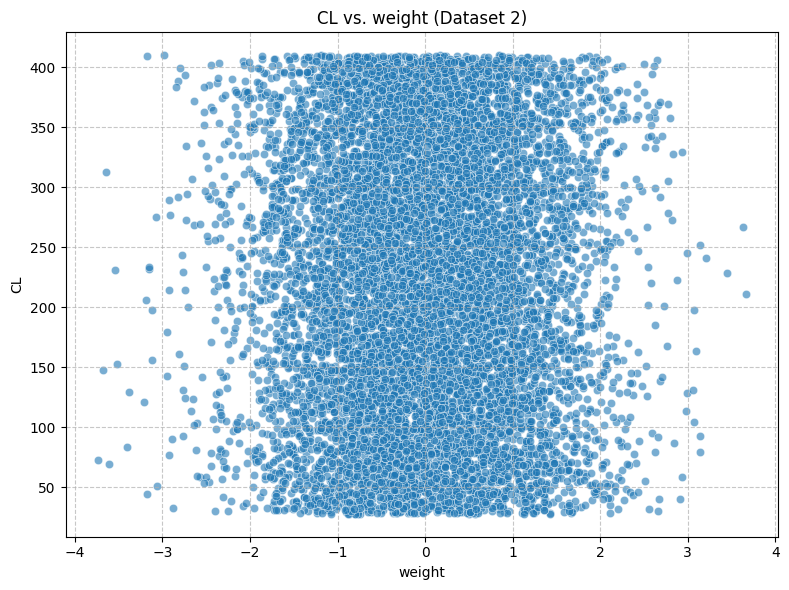

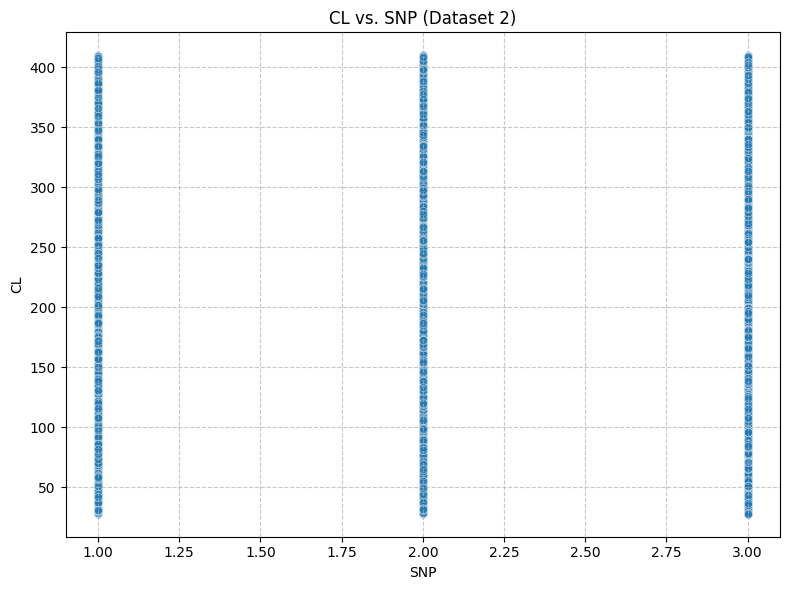

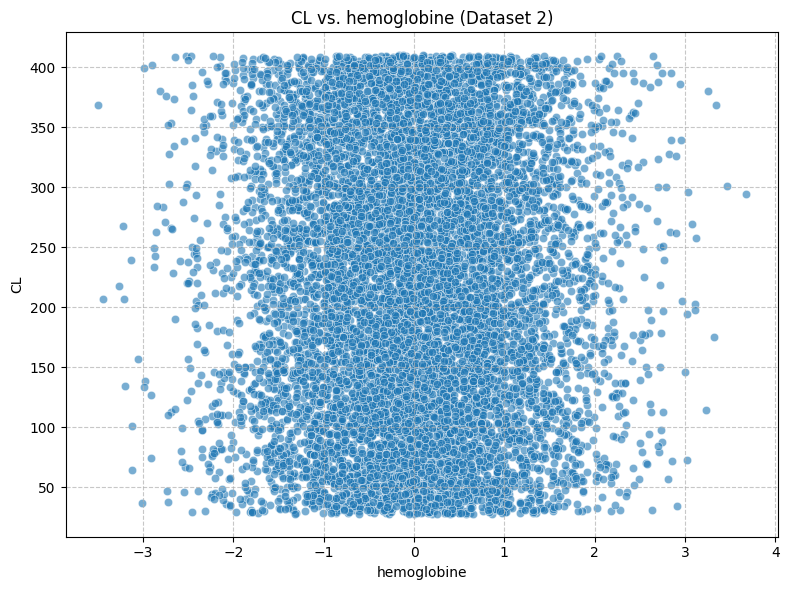

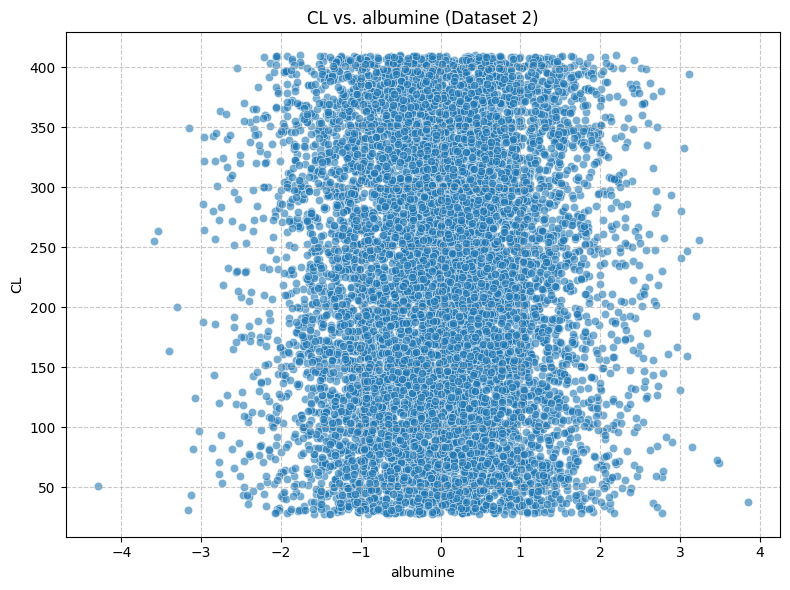

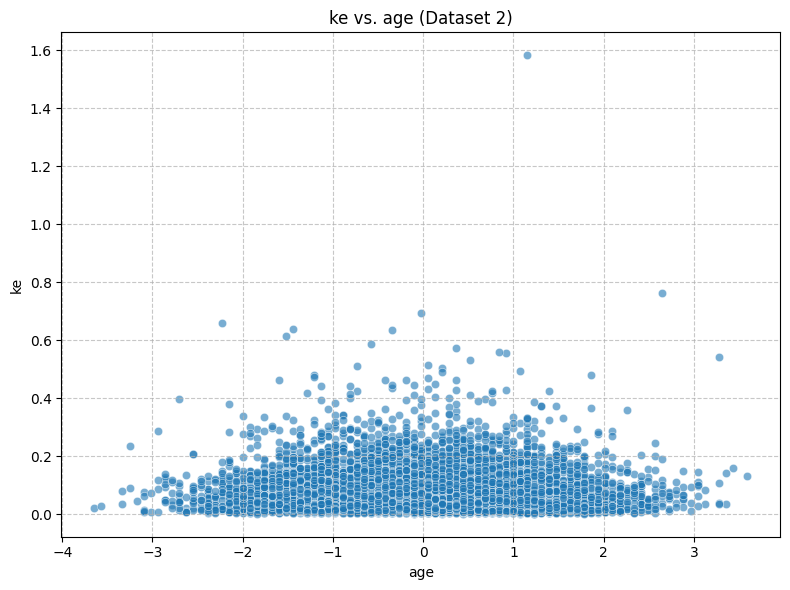

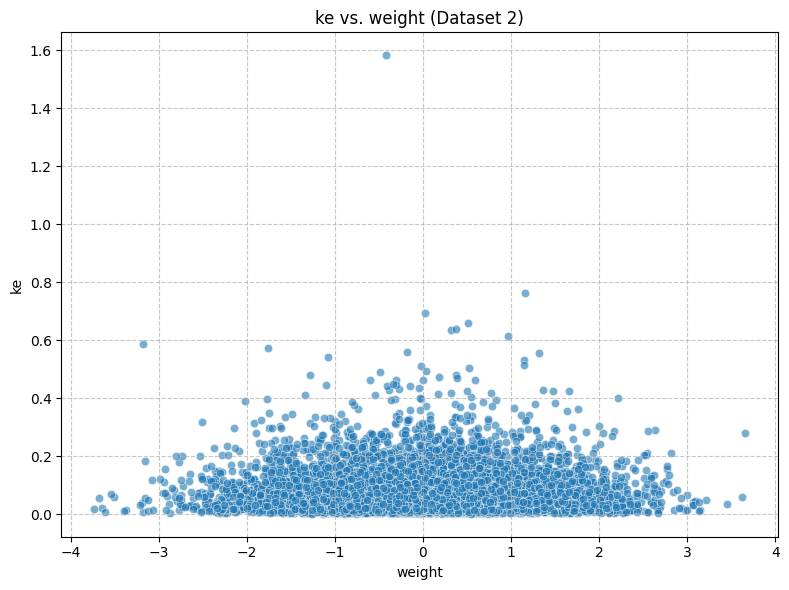

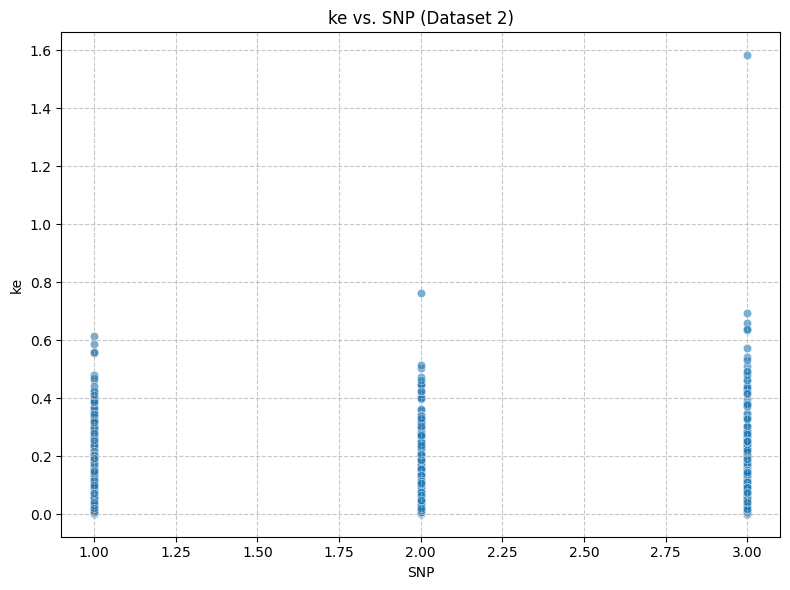

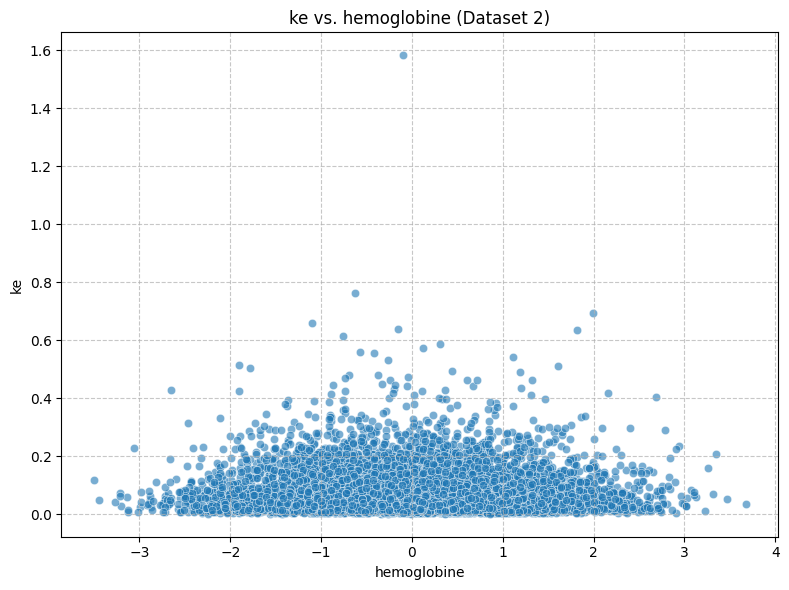

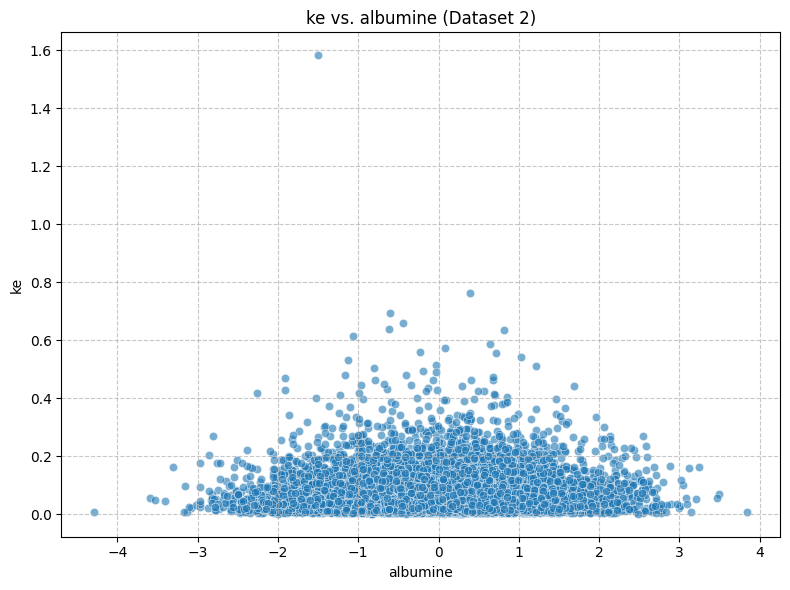

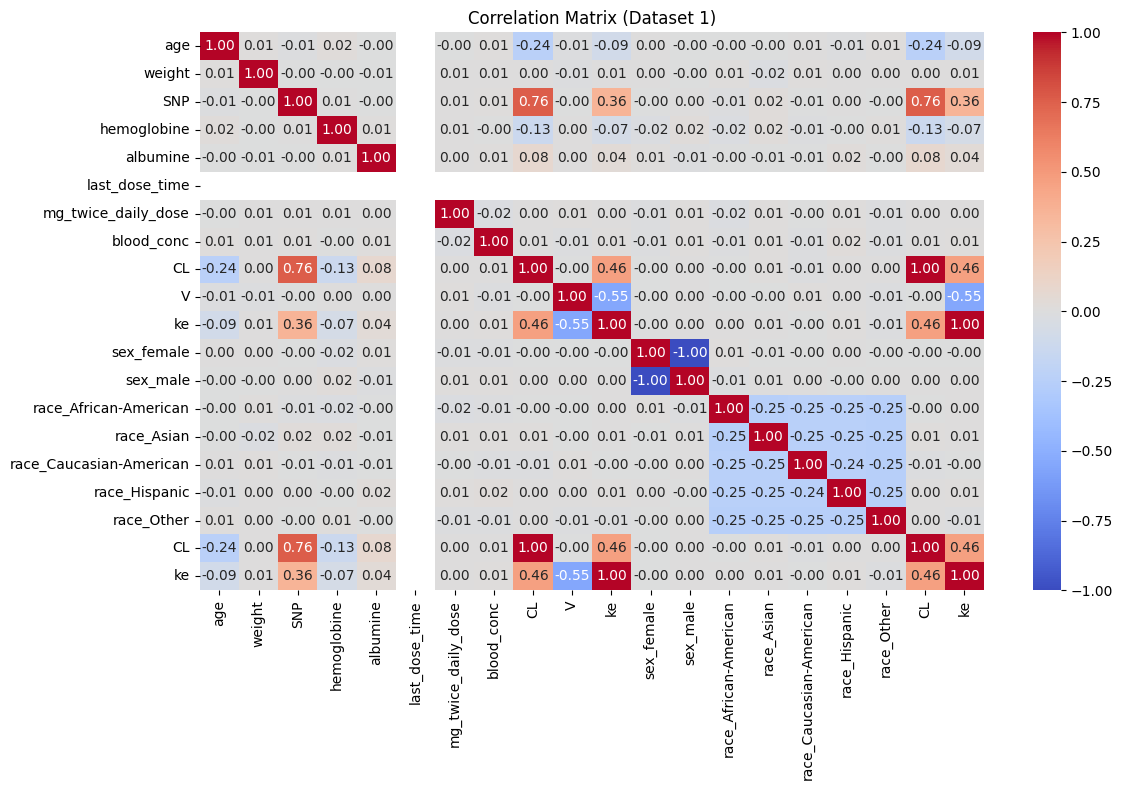

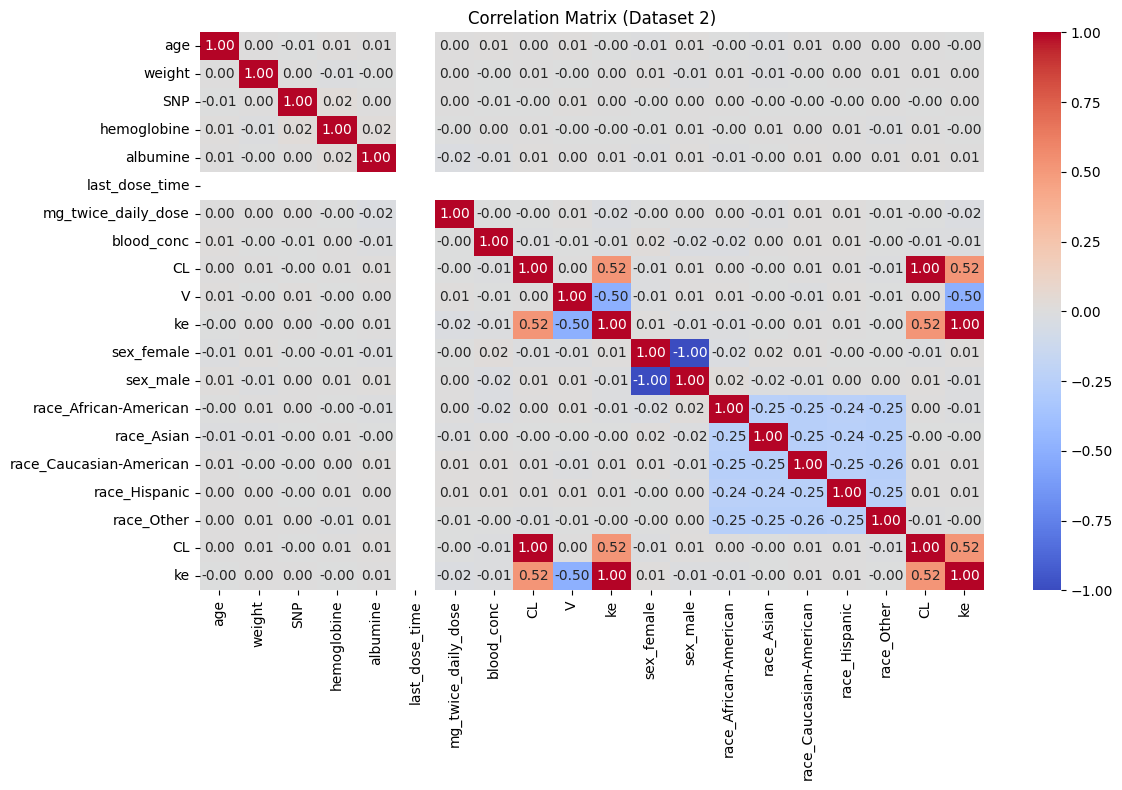

In [ ]:
# Scatter plot for CL and ke vs. covariates
scatter_plot_cl_ke(cov_processed1, cov_processed1[['CL', 'ke']], "Dataset 1")
scatter_plot_cl_ke(cov_processed2, cov_processed2[['CL', 'ke']], "Dataset 2")

# Correlation matrix for covariates and PK parameters
correlation_matrix(cov_processed1, cov_processed1[['CL', 'ke']], "Dataset 1")
correlation_matrix(cov_processed2, cov_processed2[['CL', 'ke']], "Dataset 2")
